# Error analysis oggm_v16 versions:

In [180]:
from oggm import cfg, workflow, utils, shop
import pandas as pd
import os, glob
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

cfg.initialize()

import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 8)

# makes sure that the pandas output columns are not cropped!
pd.set_option("max_colwidth", None)


2023-05-31 16:52:13: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-31 16:52:13: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-31 16:52:13: oggm.cfg: Multiprocessing: using all available processors (N=32)


In [186]:
rgi_reg_l = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg <10:
        rgi_reg = f'0{rgi_reg}'
    else:
        rgi_reg = f'{rgi_reg}'
    rgi_reg_l.append(rgi_reg)
rgi_reg_l.append('all')


In [ ]:
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup/'


In [195]:
opts = ['dynamic melt_f calibration (full success)', 'dynamic melt_f calibration (part success)', 'dynamic spinup only','fixed geometry spinup']
opts_w = ['dynamic melt_f calibration (full success)_ratio', 'dynamic melt_f calibration (part success)_ratio', 'dynamic spinup only_ratio','fixed geometry spinup_ratio']

columns = ['rgi_reg', 'option','version','border', 'perc_area_miss', 'perc_glac_miss'] + opts + opts_w
pd_stats_l = []
working_rgis_l = []
for option in ['W5E5_spinup', 'W5E5_spinup_10', 'W5E5']:
    for version in ['2023.2', '2023.3']:
        for border in ['b_080', 'b_160']:
            if (version == '2023.2') and (border == 'b_080'):
                continue
            elif (option == 'W5E5_spinup_10') and ((version == '2023.2') or (border == 'b_080')): 
                continue
            else:
                pd_stats = pd.DataFrame(columns=columns,
                                index = rgi_reg_l)
                path = '/home/www/oggm/gdirs/oggm_v1.6/'
                add = f'L3-L5_files/{version}/elev_bands/{option}/RGI62/{border}/L5/summary/'
                stats_l = []
                for rgi_reg in rgi_reg_l[:-1]:
                    stats_l.append(pd.read_csv(path+add+f'glacier_statistics_{rgi_reg}.csv', low_memory=False))
                stats = pd.concat(stats_l)  

                stats_w = stats.loc[stats.error_msg.isna()]
                working_rgis_l.append(stats_w.rgi_id.values)
                perc_area_miss = 100-100*stats_w.rgi_area_km2.sum()/stats.rgi_area_km2.sum()
                perc_glac_miss = 100-100*stats_w.rgi_id.count()/stats.rgi_id.count()
                if 'W5E5_spinup' in option:
                    stats_spinup_option = tuple(stats.groupby(['used_spinup_option']).count()['rgi_id'].loc[opts].values)
                    stats_spinup_option_w = tuple(stats_w.groupby(['used_spinup_option']).count()['rgi_id'].loc[opts].values/len(stats))
                    print(stats.loc[stats.rgi_id=='RGI60-11.01450']['used_spinup_option'])
                else:
                    stats_spinup_option = (np.NaN, np.NaN, np.NaN, np.NaN)
                    stats_spinup_option_w = (np.NaN, np.NaN, np.NaN, np.NaN)

                pd_stats.loc['all'] = ('all',option,version, border, perc_area_miss,perc_glac_miss)+stats_spinup_option+stats_spinup_option_w
                for rgi_r in np.arange(1,20,1):
                    stats_r = stats.loc[stats.rgi_region==rgi_r]
                    if 'W5E5_spinup' in option:
                        _p = stats_r.groupby(['used_spinup_option']).count()['rgi_id']
                        # it can be that one of the options occurs for none of the glaciers in one RGI region
                        for o in opts:
                            if o not in _p.index:
                                _p.loc[o] = 0
                        stats_spinup_option = tuple(_p.loc[opts].values)
                    else:
                        stats_spinup_option = (np.NaN, np.NaN, np.NaN, np.NaN)
                    rgi_reg = str(rgi_r).zfill(2)
                    stats_w_r = stats_r.loc[stats_r.error_msg.isna()]
                    if 'W5E5_spinup' in option:
                        _p = stats_w_r.groupby(['used_spinup_option']).count()['rgi_id']
                        # it can be that one of the options occurs for none of the glaciers in one RGI region
                        for o in opts:
                            if o not in _p.index:
                                _p.loc[o] = 0
                        stats_spinup_option_w = tuple(_p.loc[opts].values/len(stats_r))
                    else:
                        stats_spinup_option_w = (np.NaN, np.NaN, np.NaN, np.NaN)
                    
                    perc_area_miss = 100-100*stats_w_r.rgi_area_km2.sum()/stats_r.rgi_area_km2.sum()
                    perc_glac_miss = 100-100*stats_w_r.rgi_id.count()/stats_r.rgi_id.count()
                    pd_stats.loc[rgi_reg] = (rgi_reg,option,version, border, perc_area_miss,perc_glac_miss) + stats_spinup_option + stats_spinup_option_w
                pd_stats_l.append(pd_stats.reset_index())

1449    dynamic melt_f calibration (full success)
Name: used_spinup_option, dtype: object
1449    dynamic melt_f calibration (full success)
Name: used_spinup_option, dtype: object
1449    dynamic melt_f calibration (full success)
Name: used_spinup_option, dtype: object
1449    dynamic melt_f calibration (full success)
Name: used_spinup_option, dtype: object


In [196]:
len(common_working_rgi_ids)

212929

In [197]:
common_working_rgi_ids = set(working_rgis_l[0])
for lst in working_rgis_l[1:]:
    common_working_rgi_ids = common_working_rgi_ids.intersection(lst)
common_working_rgi_ids = list(common_working_rgi_ids)

In [198]:
pd.DataFrame(index=common_working_rgi_ids).to_csv('/home/www/lschuster/runs_oggm_v16/analysis_notebooks/common_working_rgi_ids_prepro_2023.3_vs_2023.2_w10.csv')

In [210]:
pd_stats_all = pd.concat(pd_stats_l).reset_index()
ind_n_l = []
for k in pd_stats_all.index:
    o,v,b = pd_stats_all[['option','version','border']].iloc[k].values
    ind_n = f'{o}_{v}_{b}'
    ind_n_l.append(ind_n)
pd_stats_all['option_version_border'] = ind_n_l
pd_stats_all['dynamic melt_f calibration (full+part success)'] = (pd_stats_all['dynamic melt_f calibration (full success)'] + 
                                                                  pd_stats_all['dynamic melt_f calibration (part success)'])
#pd_stats_all['dynamic melt_f calibration (full+part success)_ratio'] = (pd_stats_all['dynamic melt_f calibration (full success)_ratio'] + 
#                                                                  pd_stats_all['dynamic melt_f calibration (part success)_ratio'])
pd_stats_all['total'] = (pd_stats_all['dynamic melt_f calibration (full+part success)']+
                         pd_stats_all['fixed geometry spinup']+
                         pd_stats_all['dynamic spinup only'])


pd_stats_all['dynamic calib full success / total (%)'] = 100*(pd_stats_all['dynamic melt_f calibration (full success)'] / pd_stats_all['total'])
pd_stats_all['dynamic calib full + part success / total (%)'] = 100*(pd_stats_all['dynamic melt_f calibration (full+part success)'] / pd_stats_all['total'])

#pd_stats_all['dynamic calib full success_ratio / total (%)'] = 100*pd_stats_all['dynamic melt_f calibration (full success)_ratio'] #/ pd_stats_all['total'])
#pd_stats_all['dynamic calib full + part success_ratio / total (%)'] = 100*pd_stats_all['dynamic melt_f calibration (full+part success)_ratio']# / pd_stats_all['total'])

In [211]:
pd_all = pd_stats_all.loc[pd_stats_all.rgi_reg=='all']

In [220]:
pd_all[['rgi_reg', 'option', 'version', 'border',
       'perc_area_miss', 'perc_glac_miss',
       'dynamic melt_f calibration (full success)',
       'dynamic melt_f calibration (part success)', 'dynamic spinup only',
       'fixed geometry spinup','dynamic melt_f calibration (full+part success)','total']]

rgi_reg          option version border perc_area_miss perc_glac_miss  \
19      all     W5E5_spinup  2023.2  b_160       0.095824       0.930192   
39      all     W5E5_spinup  2023.3  b_080       0.102574       1.072156   
59      all     W5E5_spinup  2023.3  b_160       0.098552       1.022051   
79      all  W5E5_spinup_10  2023.3  b_160       0.099842       1.079115   
99      all            W5E5  2023.2  b_160        0.09531       0.902819   
119     all            W5E5  2023.3  b_080       0.097996       0.936687   
139     all            W5E5  2023.3  b_160        0.09531       0.902819   

    dynamic melt_f calibration (full success)  \
19                                     196621   
39                                     186128   
59                                     185467   
79                                     178793   
99                                        NaN   
119                                       NaN   
139                                       NaN   

    dynamic melt_f calibration (part success) dynamic spinup only  \
19                                       2082                1139   
39                                       9322                4437   
59                                       9922                4453   
79                                      16358                4691   
99                                        NaN                 NaN   
119                                       NaN                 NaN   
139                                       NaN                 NaN   

    fixed geometry spinup dynamic melt_f calibration (full+part success)  \
19                  14485                                         198703   
39                  14441                                         195450   
59                  14485                                         195389   
79                  14485                                         195151   
99                    NaN                                            NaN   
119                   NaN                                            NaN   
139                   NaN                                            NaN   

      total  
19   214327  
39   214328  
59   214327  
79   214327  
99      NaN  
119     NaN  
139     NaN

In [223]:
178793/214327

0.8342066095265646

<AxesSubplot:xlabel='option_version_border', ylabel='rgi_reg'>

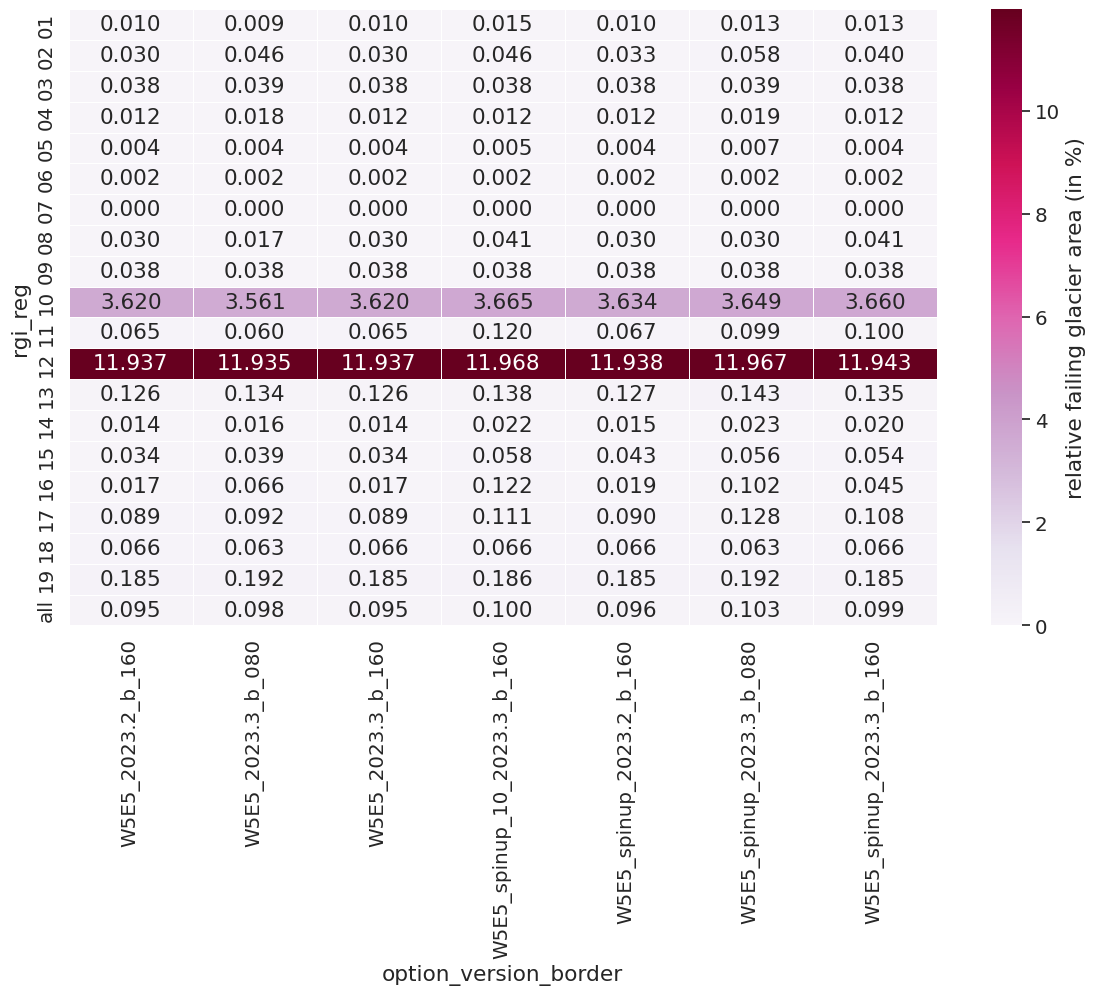

In [216]:
pd_sel_area_miss = pd_stats_all[['rgi_reg','option_version_border','perc_area_miss']].pivot(columns='option_version_border', index = 'rgi_reg')
pd_sel_area_miss.columns = pd_sel_area_miss.columns.get_level_values(1)
pd_sel_area_miss = pd_sel_area_miss.astype(float)
sns.heatmap(pd_sel_area_miss,
            #y= 'rgi_reg', x='option_version_border',
            linewidths=.5, cmap="PuRd", cbar_kws={'label':'relative failing glacier area (in %)'},
           annot=True, fmt=".3f")

<AxesSubplot:xlabel='option_version_border', ylabel='rgi_reg'>

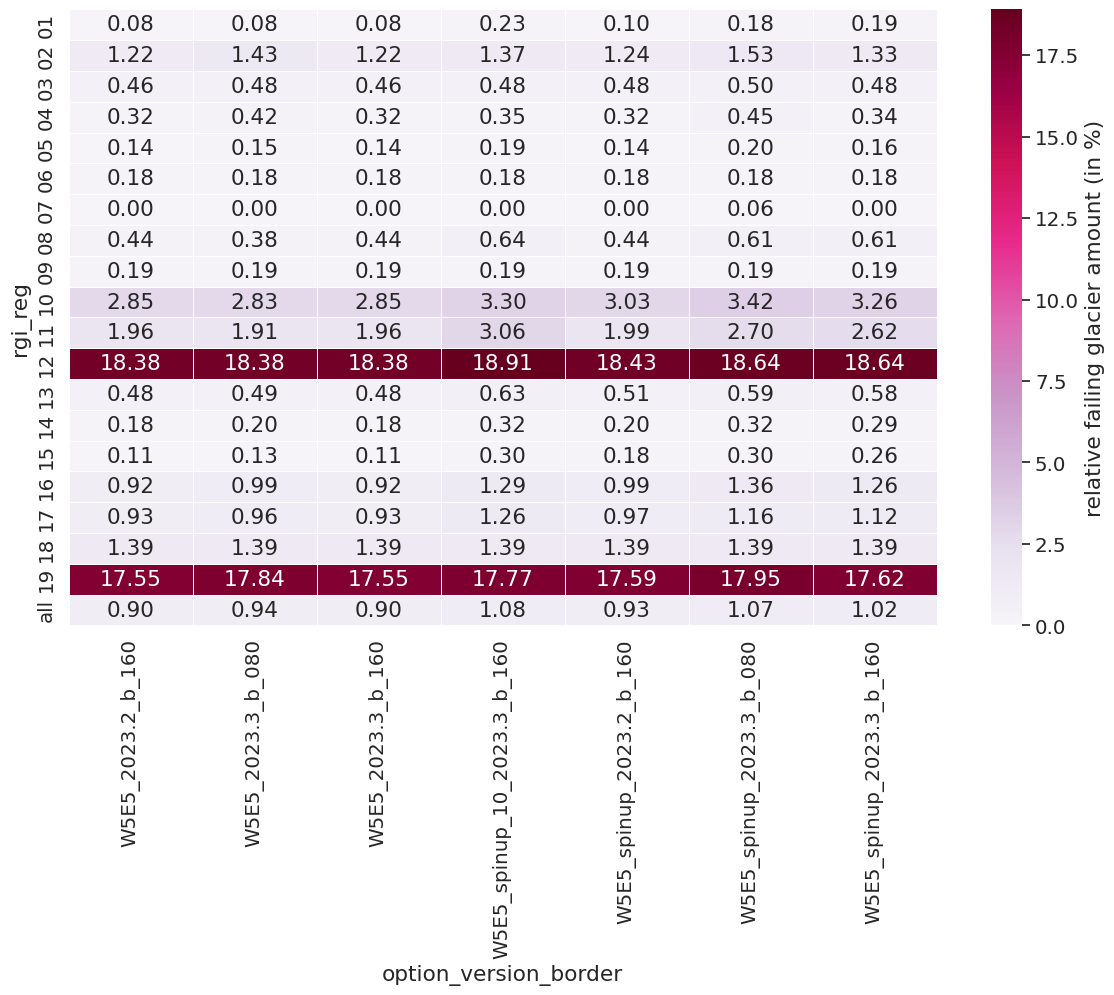

In [221]:
pd_sel_glac_miss = pd_stats_all[['rgi_reg','option_version_border','perc_glac_miss']].pivot(columns='option_version_border', index = 'rgi_reg')
pd_sel_glac_miss.columns = pd_sel_glac_miss.columns.get_level_values(1)
pd_sel_glac_miss = pd_sel_glac_miss.astype(float)
sns.heatmap(pd_sel_glac_miss,
            #y= 'rgi_reg', x='option_version_border',
            linewidths=.5, cmap="PuRd", cbar_kws={'label':'relative failing glacier amount (in %)'},
           annot=True, fmt=".2f")

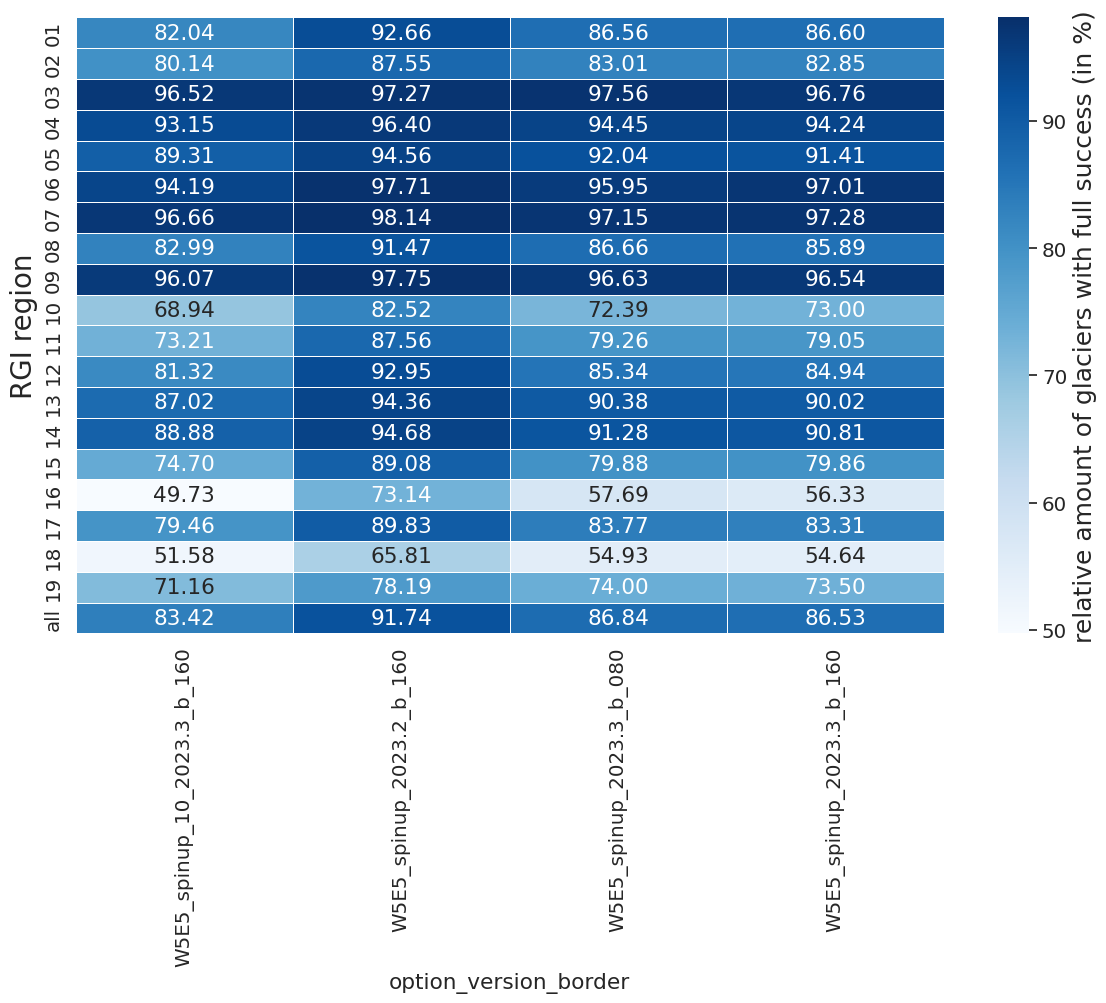

In [222]:
sns.set(font_scale = 1.3)

pd_sel_dynamic_success_total = pd_stats_all[['rgi_reg','option_version_border','dynamic calib full success / total (%)']].pivot(columns='option_version_border', index = 'rgi_reg')

pd_sel_dynamic_success_total.columns = pd_sel_dynamic_success_total.columns.get_level_values(1)
pd_sel_dynamic_success_total = pd_sel_dynamic_success_total.astype(float)
pd_sel_dynamic_success_total = pd_sel_dynamic_success_total.dropna(axis=1, how='all')

sns.heatmap(pd_sel_dynamic_success_total,
            #y= 'rgi_reg', x='option_version_border',
            linewidths=.5, cmap="Blues", cbar_kws={'label':'relative amount of glaciers with full success (in %)'},
           annot=True, fmt=".2f")
ax = plt.gca()
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.set_ylabel('RGI region', fontsize=20);

In [ ]:
sns.set(font_scale = 1.3)

pd_sel_dynamic_success_total = pd_stats_all[['rgi_reg','option_version_border','dynamic calib full success_w/ total (%)']].pivot(columns='option_version_border', index = 'rgi_reg')

pd_sel_dynamic_success_total.columns = pd_sel_dynamic_success_total.columns.get_level_values(1)
pd_sel_dynamic_success_total = pd_sel_dynamic_success_total.astype(float)
pd_sel_dynamic_success_total = pd_sel_dynamic_success_total.dropna(axis=1, how='all')

sns.heatmap(pd_sel_dynamic_success_total,
            #y= 'rgi_reg', x='option_version_border',
            linewidths=.5, cmap="Blues", cbar_kws={'label':'relative amount of working glaciers with full success vs total glaciers (in %)'},
           annot=True, fmt=".2f")
ax = plt.gca()
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.set_ylabel('RGI region', fontsize=20);

#### OLD???

In [ ]:
sns.set(font_scale = 1.3)
plt.figure(figsize=(16,10))
plt.subplot(111)
plt.title('Relative failing glacier area per RGI region\n(match_geod_pergla, qc0)', fontsize=20)
#plt.title(', fontsize=22)
pd_stats_all_sel
sns.heatmap(pd_stats_all,
            linewidths=.5, cmap="PuRd", cbar_kws={'label':'relative failing glacier area (in %)'},
           annot=True, fmt=".2f")
ax = plt.gca()
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.set_ylabel('RGI region', fontsize=20);
ax.set_xticklabels(['CRU_pcp2.5\n(b80)', 'ERA5_pcp1.6\n(b80)', 'W5E5_pcp2.6\n(b160)', 'W5E5_pcp_via\nwinter_prcp (b160)'])
ax.set_xlabel('climate dataset & prcp. fac', fontsize=20)
plt.savefig('relative_failing_glacier_area_regional_match_geod_pergla_clim_pcp.png')

plt.figure(figsize=(24,10))
plt.subplot(122)
ax = plt.gca()
sns.boxplot(x = 'rgi_region', y='glacier_prcp_scaling_factor', data = pd_glac_stats_all, ax = ax)
plt.axhline(2.6, ls= '--', lw = 3, color = 'grey', label = 'applied constant prcp. fac\n(median from reference glaciers matching std.)')
plt.axhline(pd_glac_stats_all['glacier_prcp_scaling_factor'].quantile([0.5]).values,
            ls= ':', lw = 3, color = 'gray', label = 'median prcp. fac over all glaciers')
plt.legend()
plt.title('glacier-specific varying prcp. fac depending on the winter prcp. (using W5E5)', fontsize=20)

plt.subplot(121)
ax = plt.gca()
sns.boxplot(x = 'rgi_region', y='winter_prcp', data = pd_glac_stats_all, ax = ax)

plt.legend()
plt.ylabel(r'winter daily precipitation (kg m$^{-2}$, avg. 1979-2019)')
plt.title('(uncorrected) winter prcp. with W5E5', fontsize=20)
plt.tight_layout()
plt.savefig('W5E5_prcp_fac_via_winterpcp_boxplots.png')


In [35]:
def error_analysis_w_plot(dfserr={}, pd_rel_error_area = None,
                          level='L2', exp='elev_bands', pcp ='', clim='', 
                          qc = '', match = '', border = 160,
                          version = '',
                          rgi_reg = 'all', 
                          path = '/home/www/oggm/gdirs/oggm_v1.6/', subplot = False, xlim=None, plot=True, rename_match =True):
    """ Estimates for a specific preprocessed gdirs the relative glacier area with errors
    and the relative amount of glaciers with errors (both in %). 
    
    Plots the error counts for the different error types.
    
    Works only if the glacier statistics were estimated!
    
    Parameters
    ----------
    dfserr : dictionary
        dictionary where already errors of largest glaciers from other preprocessed gdirs are saved, default is an empty dictionary
    pd_rel_error_area : pd.DataFrame
        pandas DataFrame with statistics about relative area and amount of errors on glaciers. 
        Default is None, which creates a new pandas DataFrame
    level : str
        the preprocessing level where the errors should be estimated and plotted.
        So far, it works only for 'L2' and 'L5'. Default is 'L2'.
    exp : str
        which glacier flowlines are used. Either 'elev_bands' (default) or 'centerlines'
    pcp : str
        precipitation factor applied (depends on clim). Has to be set!
    clim : str
        which baseline is applied. Either 'ERA5' or 'CRU'. Has to be set!
    qc : str
        whether a glacier climate quality check and correction was applied. If yes, set it to 'qc3', 
        otherwise to 'qc0'. Has to be set!
    match: str
        which calibration & other methods are chosen: Has to be set if above level 2!
        - "no_match" : only direct glaciological WGMS data used
        - "match_geod" : same as no_match, but regionally the geodetic estimates are matched by changing epsilon
        - "match_geod_pergla" : only per-glacier-individual geodetic estimates of Hugonnet et al. (2021) matched
        - "match_geod_pergla_massredis" : same as match_geod_pergla, but instead of the Shallow-Ice Approximation, 
          a mass-redistribution is applied (see: https://docs.oggm.org/en/latest/mass-redistribution.html)
    border : str
        which size of the local glacier map was used (prepro_border). For qc0, e.g., 
        most preprocessing directories are available for border=80. Default is 160
    rgi_reg : str
        default is all RGI regions. But you can also choose a single RGI region (e.g. rgi_reg = '11') or all RGI 
        regions except 19 (i.e. not available for CRU!, rgi_reg='all_without_19')
    path : str
        path to the general gdirs folder
    subplot : bool
        Default is False. If you want to use several plots, set it to True
    xlim : int
        Default is None. Maximum of single type errors in the plot. Useful for subplots
    plot : bool
        If an error type plot should be returned or not!
    
    Returns
    -------
    dfserr : dictionary
        dictionary where for each preprocessed gdir, a pd.DataFrame exists which lists the 
        type of errors and area of the 15 largest glaciers with errors
    pd_rel_error_area : pd.DataFrame
        pandas DataFrame with statistics about relative area and amount of errors on glaciers. 
        If repeated, for several preprocessed gdirs, each row represents the statistics of 
        one preprocessed gdirs.
        
    """
    if clim == 'CRU' and rgi_reg == 'all':
        raise InvalidParamsError("CRU is NOT available for RGI 19, use rgi_reg='all_without_19' instead")
    if pd_rel_error_area is None:
        pd_rel_error_area = pd.DataFrame(columns=['rel_error_area_in_percent', 'level', 'exp', 'pcp_clim', 'match', 'qc'])

    if level == 'L2':
        fd = f'{path}/L1-L2_files/{exp}/RGI62/b_{border:03d}/L2/summary/'
        err_msg = "In preprocessing level 2, climate, precipitation factor and qc should not be defined"
        assert pcp == '' and clim == '' and qc == '', err_msg
        title = f'{level}: {exp}, border: {border}'
        dict_key = f'{level}_{exp}_b{border}_rgi_{rgi_reg}'
    elif level == 'L5':
        if (pcp == 'via_winterprcp') or (pcp == '2.6'):
            fd = f'{path}/L3-L5_files/{clim}/{exp}/{qc}/{match}/RGI62/b_{border:03d}/L5/summary/'
        elif pcp == 'v1.6':
            fd = f'{path}/L3-L5_files/{version}/{exp}/{clim}/RGI62/b_{border:03d}/L5/summary/'
        else:
            fd = f'{path}/L3-L5_files/{clim}/{exp}/{qc}/{pcp}/{match}/RGI62/b_{border:03d}/L5/summary/'
        #err_msg = "In preprocessing level 5, need to prescribe climate (clim), match, precipitation factor (pcp) and quality check type (qc)"
        #assert pcp != '' and clim != '' and qc != '' and match !='' , err_msg

        title = f'{level}: {exp}, {pcp}, {clim}, {match}, {qc}, border: {border}, rgi_{rgi_reg}, version: {version}'
        dict_key = f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}_b{border}_rgi_{rgi_reg}_version_{version}'
    else:
        raise InvalidParamsError('Only L2 and L5 can be used, but the function can be adapted easily in order that it works for other levels!')
        
    # get the statistics file which lists errors and their type
    fs = glob.glob(fd+'glacier_statistics*.csv')
    
    if rgi_reg == 'all_without_19':
        for f in fs:
            if 'statistics_19' in f:
                fs.remove(f)
        assert len(fs) == 18
    elif rgi_reg == 'all':
        print(len(fs))
        assert len(fs) == 19
    else:
        for f in fs:
            if f'statistics_{rgi_reg}' in f:
                fs = [f]
                break
        assert len(fs) == 1
    
    df = []
    for f in fs:
        df.append(pd.read_csv(f, index_col=0, low_memory=False))
    df = pd.concat(df).sort_index()
    
    rel_error_area = df.loc[~df['error_task'].isnull()].rgi_area_km2.sum() / df.rgi_area_km2.sum() * 100
    
    # plot the amount of errors for each error type
    if plot:
        title = title + '\n relative glacier area with errors: {:.2f}%'.format(rel_error_area)
        if not subplot:
            plt.figure()
        plt.title(title, fontsize=12)
        sns.countplot(y="error_task", data=df.sort_values(by='error_task'));
        if xlim is not None:
            plt.xlim([0,xlim])

    # save the glaciers that result in errors sorted from largest to smallest glacier area
    dfserr[dict_key] = df.loc[~df['error_task'].isnull()].sort_values(by='rgi_area_km2', ascending=False)[['rgi_area_km2', 'error_task', 'error_msg']]
    # .iloc[:15]
    # save statistics about relative area and amount of errors on glaciers
    pd_rel_error_area.loc[dict_key] = np.NaN
    pd_rel_error_area.loc[dict_key]['rel_error_area_in_percent'] = rel_error_area
    pd_rel_error_area.loc[dict_key]['rgi_reg'] = rgi_reg
    pd_rel_error_area.loc[dict_key]['level'] = level
    pd_rel_error_area.loc[dict_key]['border'] = border
    pd_rel_error_area.loc[dict_key]['exp'] = exp
    if rename_match:
        if match == 'match_geod_pergla_2.6':
            pd_rel_error_area.loc[dict_key]['match'] = match[:-4]
        elif match == 'match_geod_pergla_winterprcp':
            pd_rel_error_area.loc[dict_key]['match'] = 'match_geod_pergla'

        else:
            pd_rel_error_area.loc[dict_key]['match'] = match
    else:
        pd_rel_error_area.loc[dict_key]['match'] = match

    pd_rel_error_area.loc[dict_key]['clim_pcp'] = f'{clim}_{pcp}'
    pd_rel_error_area.loc[dict_key]['qc'] = qc
    
    return dfserr, pd_rel_error_area

In [36]:
# could be changed, but not all pre-processed directories are available for all prepro_border options!
border = 160 # 80 if qc0
# these are just containers to save and later compare the error statistics! 
dfserr = {}
pd_rel_error_area = pd.DataFrame(columns=['rel_error_area_in_percent', 'level', 'exp',
                                          'clim_pcp', 'match', 'qc', 'border', 'rgi_reg'])

## Analysis for Level 2 pre-processing directories!

In pre-processing level 2, we only distinguish between elevation bands and centerlines (see the [Flowlines documentation](https://docs.oggm.org/en/stable/flowlines.html#glacier-flowlines) for an explanation about the differences). 

19
19


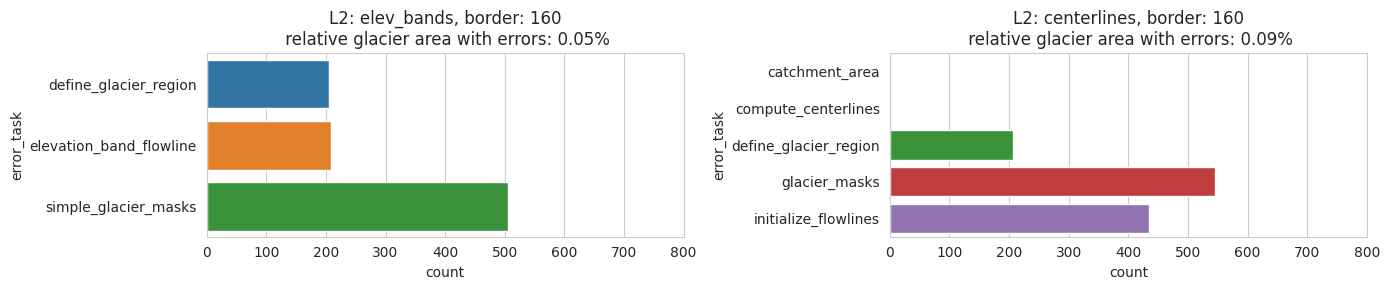

In [37]:
plt.figure(figsize=(14,3))
plt.subplot(121)
dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area,
                                                  level='L2', subplot=True,
                                                  exp='elev_bands', border=border, xlim = 800)
plt.subplot(122)
dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area,
                                                  level='L2',  subplot=True,
                                                  exp='centerlines', border=border, xlim = 800)
plt.tight_layout()

- failing glacier area on pre-processing level 2 is ~0.1% or less
- less glaciers will fail when using elev_bands than centerlines

**Here you can analyse the failing glaciers with the largest area and the type of error that has occurred!**

In [7]:
dfserr['L2_elev_bands_b160_rgi_all'].head()

rgi_area_km2             error_task  \
rgi_id                                                
RGI60-10.00002        48.144   simple_glacier_masks   
RGI60-19.01418        20.427  define_glacier_region   
RGI60-10.00006        12.966   simple_glacier_masks   
RGI60-12.01364         9.250   simple_glacier_masks   
RGI60-09.00635         8.144  define_glacier_region   

                                                                                                                       error_msg  
rgi_id                                                                                                                            
RGI60-10.00002                                                               GeometryError: RGI60-10.00002 is a nominal glacier.  
RGI60-19.01418  HttpDownloadError: (403, 'https://download.geoservice.dlr.de/TDM90/files/DEM/S75/W130/TDM1_DEM__30_S75W134.zip')  
RGI60-10.00006                                                               GeometryError: RGI60-10.00006 is a nominal glacier.  
RGI60-12.01364                                                               GeometryError: RGI60-12.01364 is a nominal glacier.  
RGI60-09.00635  HttpDownloadError: (403, 'https://download.geoservice.dlr.de/TDM90/files/DEM/N79/E050/TDM1_DEM__30_N79E058.zip')

In [8]:
dfserr['L2_centerlines_b160_rgi_all'].head()

rgi_area_km2             error_task  \
rgi_id                                                
RGI60-19.01521        94.963   initialize_flowlines   
RGI60-10.00002        48.144          glacier_masks   
RGI60-03.04079        35.752   initialize_flowlines   
RGI60-19.00780        25.152   initialize_flowlines   
RGI60-19.01418        20.427  define_glacier_region   

                                                                                                                       error_msg  
rgi_id                                                                                                                            
RGI60-19.01521                                      RuntimeError: Altitude range of main flowline too small: 0.11659260120634536  
RGI60-10.00002                                                               GeometryError: RGI60-10.00002 is a nominal glacier.  
RGI60-03.04079                                   RuntimeError: Altitude range of main flowline too small: 2.0788404120956593e-05  
RGI60-19.00780                                    RuntimeError: Altitude range of main flowline too small: 0.0031179319468100314  
RGI60-19.01418  HttpDownloadError: (403, 'https://download.geoservice.dlr.de/TDM90/files/DEM/S75/W130/TDM1_DEM__30_S75W134.zip')

Let's just look at the level 2 errors for only RGI region 12 

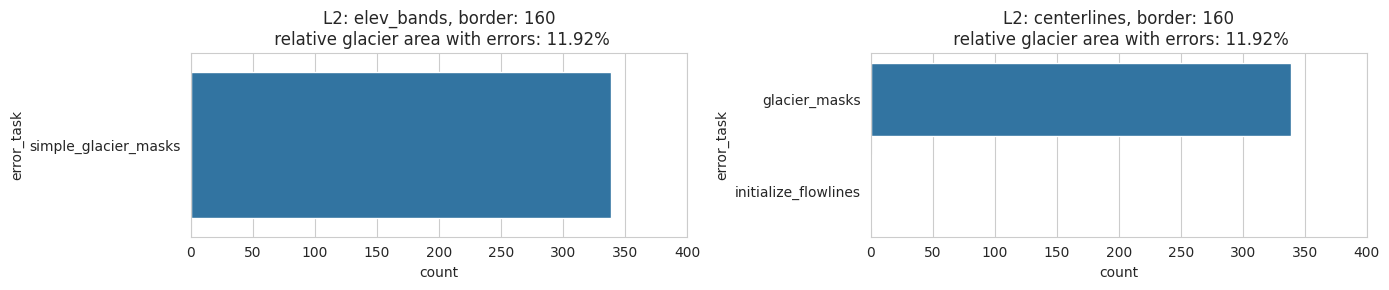

In [9]:
rgi_reg = '12'
plt.figure(figsize=(14,3))
plt.subplot(121)
dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area, level='L2', subplot=True,
                                                      exp='elev_bands', rgi_reg=rgi_reg,
                                                      border=border, xlim = 400)
plt.subplot(122)
dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area, level='L2',  subplot=True,
                                                      exp='centerlines', rgi_reg=rgi_reg,
                                                      border=border, xlim = 400)
plt.tight_layout()

In [38]:
dfserr['L2_elev_bands_b160_rgi_12']['error_msg']

rgi_id
RGI60-12.01364    GeometryError: RGI60-12.01364 is a nominal glacier.
RGI60-12.01372    GeometryError: RGI60-12.01372 is a nominal glacier.
RGI60-12.01374    GeometryError: RGI60-12.01374 is a nominal glacier.
RGI60-12.01500    GeometryError: RGI60-12.01500 is a nominal glacier.
RGI60-12.01443    GeometryError: RGI60-12.01443 is a nominal glacier.
                                         ...                         
RGI60-12.01628    GeometryError: RGI60-12.01628 is a nominal glacier.
RGI60-12.01545    GeometryError: RGI60-12.01545 is a nominal glacier.
RGI60-12.01546    GeometryError: RGI60-12.01546 is a nominal glacier.
RGI60-12.01547    GeometryError: RGI60-12.01547 is a nominal glacier.
RGI60-12.01350    GeometryError: RGI60-12.01350 is a nominal glacier.
Name: error_msg, Length: 339, dtype: object

In RGI region 12, ~12% of the glacier area can not run even in pre-processing level 2. The reasons are glacier masks errors because many of the glaciers in RGI region 12 are "nominal" glaciers. Nominal means here that the glaciers don't have a glacier outline but only a location and area and hence can not be run with OGGM. 

## Analysis for Level 5 pre-processing directories! 

In pre-processing level 5, we distinguish between:
- different flowline types (exp = 'elev_bands' or 'centerlines', see the [Flowlines documentation](https://docs.oggm.org/en/stable/flowlines.html#glacier-flowlines))
- different climate and precipitation factors (here: clim='CRU' with pcp='pcp2.5' or 'ERA5' with 'pcp1.6', or 'GSWP3_W5E5' with 'pcp2.5' or with varying prcp. fac depending on winter prcp.)
- different ways to calibrate the mass balance (see [documentation on available mass-balance calibration methods](https://docs.oggm.org/en/latest/input-data.html#d-option-mass-balance-calibration-method)):
    - match = "no_match" : only direct glaciological WGMS data used
    - match = "match_geod" : same as no_match, but regionally the geodetic estimates are matched by changing epsilon
    - match = "match_geod_pergla" : only per-glacier-individual geodetic estimates of Hugonnet et al. (2021) matched
- applying the climate quality check and correction (qc='qc3') or not (qc='qc0'), see [historical_climate_qc](https://docs.oggm.org/en/latest/generated/oggm.tasks.historical_climate_qc.html#oggm.tasks.historical_climate_qc).
    - at the moment we compare match_geod_pergla "qc0" and "qc3" although technically, after the newest OGGM release, there should be no difference in between. When we have preprocessed gdirs with match_geod_pergla with qc0, we will remove the match_geod_pergla qc3 gdirs as they will be outdated and should not be used. We will update the notebook afterwards!
- using either the default shallow-ice approximation or a simple mass-redistribution (see: https://docs.oggm.org/en/latest/mass-redistribution.html). For the mass-redistribution, we only have one preprocessed glacier directory at the moment. You can check it out under:
    - match = 'match_geod_pergla_massredis' (same as match_geod_pergla but with mass redistribution instead of SIA)

In [38]:
level = 'L5'
rgi_reg = 'all'

19
19
19
19


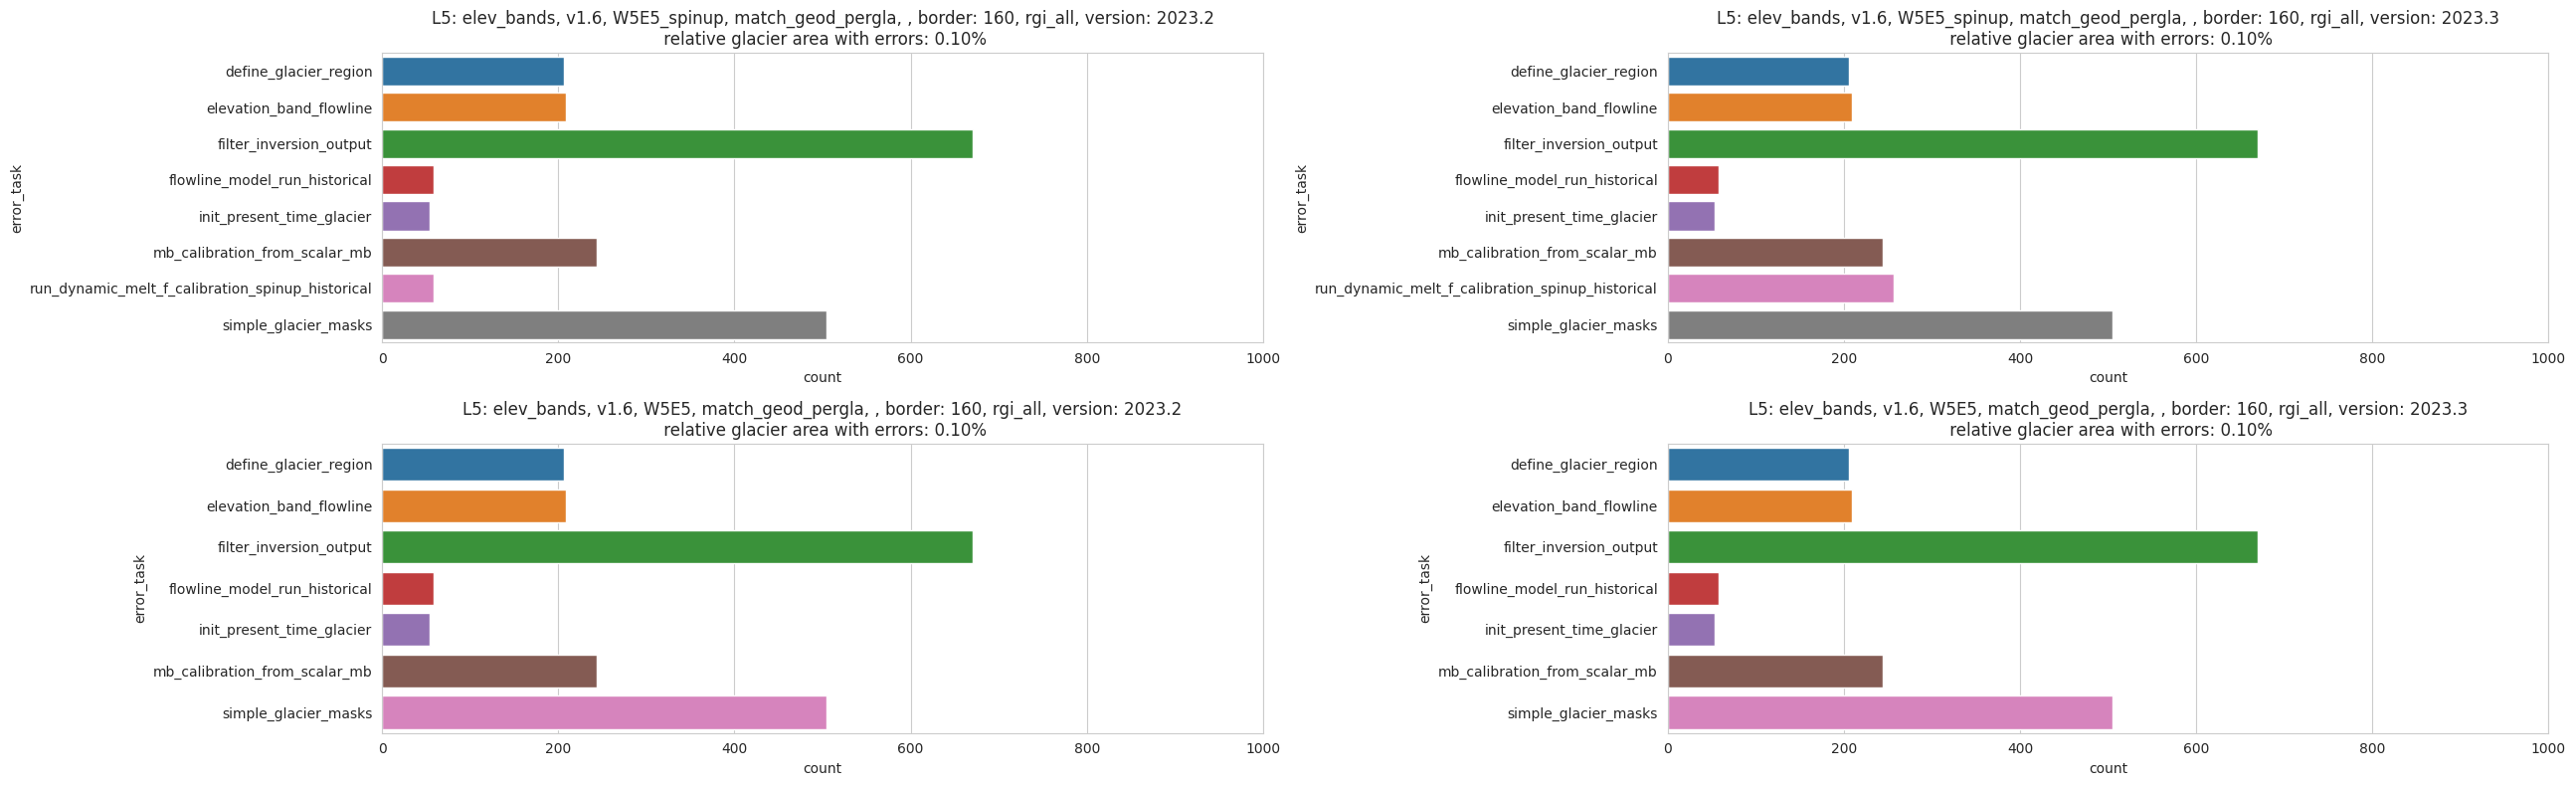

In [40]:
plt.figure(figsize=(26,8))
for j, clim in enumerate(['W5E5_spinup', 'W5E5']):
    if j == 1:
        plt.subplot(2,2,j*2+1) #, sharey=ax1)
    else:
        plt.subplot(2,2,j*2+1)
    dfserr_median_prcp_fac, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr,
                                                                      pd_rel_error_area = pd_rel_error_area,
                              level=level, exp='elev_bands', #pcp = '2.6',
                           match ='match_geod_pergla', clim=clim, 
                              version='2023.2', pcp='v1.6', border = 160,xlim=1000,
                              rgi_reg = rgi_reg, 
                              path = '/home/www/oggm/gdirs/oggm_v1.6/', subplot = True, plot=True)
    
    ax1 = plt.gca()
    
    if j == 1:
        plt.subplot(2,2,j*2+2) #, sharey=ax2)
    else:
        plt.subplot(2,2,j*2+2)
    dfserr_median_prcp_fac, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr,
                                                                      pd_rel_error_area = pd_rel_error_area,
                              level=level, exp='elev_bands', #pcp = '2.6',
                           match ='match_geod_pergla', clim=clim, 
                              version='2023.3', pcp='v1.6', border = 160,xlim=1000,
                              rgi_reg = rgi_reg, 
                              path = '/home/www/oggm/gdirs/oggm_v1.6/', subplot = True, plot=True)
    ax2 = plt.gca()
    
plt.tight_layout()

19


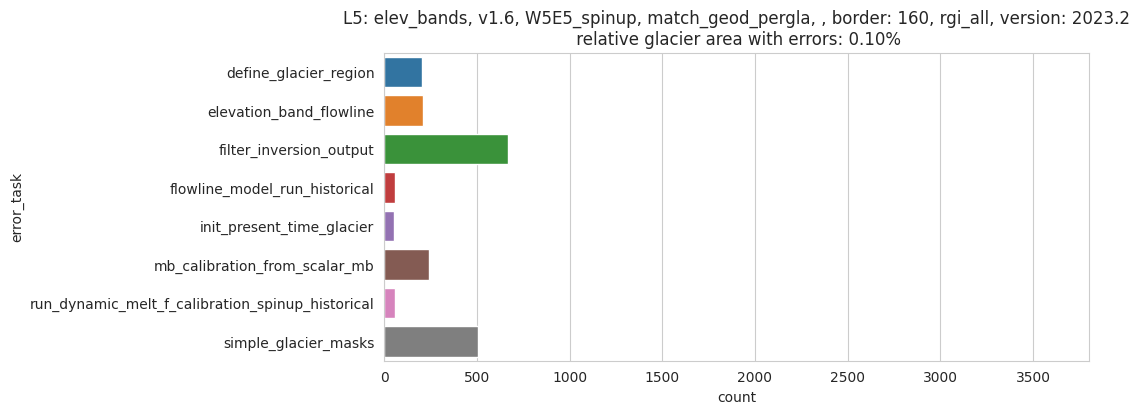

In [23]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
dfserr_median_prcp_fac, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area = pd_rel_error_area,
                          level=level, exp='elev_bands', #pcp = '2.6',
                       match ='match_geod_pergla', clim='W5E5_spinup', 
                          version='2023.2', pcp='v1.6', border = 160,xlim=3800,
                          rgi_reg = rgi_reg, 
                          path = '/home/www/oggm/gdirs/oggm_v1.6/', subplot = True, plot=True)

In [41]:
# Let's get all level 5 statistics (for both, qc0 and qc3!)
pd_rel_error_area_L5 = pd_rel_error_area[(pd_rel_error_area.level == 'L5') & (pd_rel_error_area.rgi_reg =='all')]
condi1 = (pd_rel_error_area_L5.border == 160) 
pd_rel_error_area_L5 = pd_rel_error_area_L5[condi1] #| condi2]

<a id='id-total-error-area-summary'></a>

In [43]:
pd_rel_error_area_L5

Empty DataFrame
Columns: [rel_error_area_in_percent, level, exp, clim_pcp, match, qc, border, rgi_reg]
Index: []

In [42]:
pd_rel_error_area

rel_error_area_in_percent  \
L2_elev_bands_b160_rgi_all                                                                      0.052851   
L2_centerlines_b160_rgi_all                                                                     0.086374   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.2                   0.095824   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.3                   0.098552   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.2                          0.095310   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.3                          0.095310   

                                                                               level  \
L2_elev_bands_b160_rgi_all                                                       NaN   
L2_centerlines_b160_rgi_all                                                      NaN   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.2    NaN   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.3    NaN   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.2           NaN   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.3           NaN   

                                                                               exp  \
L2_elev_bands_b160_rgi_all                                                     NaN   
L2_centerlines_b160_rgi_all                                                    NaN   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.2  NaN   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.3  NaN   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.2         NaN   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.3         NaN   

                                                                               clim_pcp  \
L2_elev_bands_b160_rgi_all                                                          NaN   
L2_centerlines_b160_rgi_all                                                         NaN   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.2       NaN   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.3       NaN   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.2              NaN   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.3              NaN   

                                                                               match  \
L2_elev_bands_b160_rgi_all                                                       NaN   
L2_centerlines_b160_rgi_all                                                      NaN   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.2    NaN   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.3    NaN   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.2           NaN   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.3           NaN   

                                                                               qc  \
L2_elev_bands_b160_rgi_all                                                    NaN   
L2_centerlines_b160_rgi_all                                                   NaN   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.2 NaN   
L5_elev_bands_v1.6_W5E5_spinup_match_geod_pergla__b160_rgi_all_version_2023.3 NaN   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.2        NaN   
L5_elev_bands_v1.6_W5E5_match_geod_pergla__b160_rgi_all_version_2023.3        NaN   

                                                                               border  \
L2_elev_bands_b160_rgi_all                                                      160.0   
L2_centerlines_b160_rgi_all                                              

In [52]:
# Let's get all level 5 statistics (for both, qc0 and qc3!)
pd_rel_error_area_L5 = pd_rel_error_area[(pd_rel_error_area.level == 'L5') & (pd_rel_error_area.rgi_reg =='all_without_19')]
# we only use border = 80 for qc0 as this is the option where most preprocessed directories are available
condi1 = ((pd_rel_error_area_L5.border == 80) & (pd_rel_error_area_L5.qc=='qc0'))
# we only use border = 160 for qc3 as this is the option where most preprocessed directories are available
condi2 = ((pd_rel_error_area_L5.border == 160) & (pd_rel_error_area_L5.qc=='qc3'))
# 
condi3 = (('GSWP3_W5E5_2.6' == pd_rel_error_area['clim_pcp']) | ('GSWP3_W5E5_via_winterprcp' == pd_rel_error_area['clim_pcp']))

pd_rel_error_area_L5 = pd_rel_error_area_L5[(condi1 |condi2|condi3)]

/tmp/ipykernel_466059/2060589157.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_rel_error_area_L5 = pd_rel_error_area_L5[(condi1 |condi2|condi3)]


### Method to get those glaciers that work for all preprocessed glacier directories? This is important when later trying to compare volume estimates between each other!

In [44]:
pd_geodetic = utils.get_geodetic_mb_dataframe()[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']
# we do not model RGI region 19 because we want to compare it to CRU!!! 
pd_geodetic = pd_geodetic[pd_geodetic.reg != 19]

total_area = pd_geodetic.area.sum()
total_counts = len(pd_geodetic)
# pd_geodetic.area
pd_working = pd.DataFrame(index = pd_geodetic.index,
                        columns=dfserr.keys())
# we will set those that are not running afterwards to np.NaN value
pd_working.loc[pd_geodetic.index] = True
pd_working['area'] = pd_geodetic.area
pd_working['all_running_rgis'] = np.NaN
pd_working['rgi_reg'] = pd_geodetic.reg


In [45]:
for key in dfserr.keys():
    if 'rgi_all_without_19' in key: 
        failing_rgis = dfserr[key].index.values



        # pd_error[cmip6_output_type] = False
        # set those glaciers that did not work to np.NaN
        pd_working.loc[failing_rgis,key] = np.NaN
        
        # check if it worked
        assert len(failing_rgis) == len(pd_working.loc[pd_working[key].isna()])
    else:
        pd_working = pd_working.drop(columns=key)
        pass


In [47]:
all_running_rgis = pd_working[pd_working.columns[:-3]].dropna().index

In [48]:
pd_working.loc[all_running_rgis, 'all_running_rgis'] = True


In [49]:
all_running_rel = len(all_running_rgis)*100/len(pd_geodetic)
all_running_rel_area = pd_working.loc[all_running_rgis].area.sum()*100/pd_working.area.sum()

print(f'Amount of glaciers (without Antarctica RGI region 19) that run without glaciers for all compared preprocessed gdirs: {len(all_running_rgis)}')
print(f'Relative percentage of glacier amount where all analysed L5 preprocessed gdirs do not fail: {all_running_rel:0.2f}%')
print(f'Relative percentage of glacier area where all analysed L5 preprocessed gdirs do not fail: {all_running_rel_area:0.2f}%')

Amount of glaciers (without Antarctica RGI region 19) that run without glaciers for all compared preprocessed gdirs: 212795
Relative percentage of glacier amount where all analysed L5 preprocessed gdirs do not fail: 100.00%
Relative percentage of glacier area where all analysed L5 preprocessed gdirs do not fail: 100.00%


In [58]:
all_running_rel = len(all_running_rgis)*100/len(pd_geodetic)
all_running_rel_area = pd_working.loc[all_running_rgis].area.sum()*100/pd_working.area.sum()

print(f'Amount of glaciers (without Antarctica RGI region 19) that run without glaciers for all compared preprocessed gdirs: {len(all_running_rgis)}')
print(f'Relative percentage of glacier amount where all analysed L5 preprocessed gdirs do not fail: {all_running_rel:0.2f}%')
print(f'Relative percentage of glacier area where all analysed L5 preprocessed gdirs do not fail: {all_running_rel_area:0.2f}%')

Amount of glaciers (without Antarctica RGI region 19) that run without glaciers for all compared preprocessed gdirs: 200674
Relative percentage of glacier amount where all analysed L5 preprocessed gdirs do not fail: 94.30%
Relative percentage of glacier area where all analysed L5 preprocessed gdirs do not fail: 93.82%


In [59]:
pd_rel_error_area_L5.to_csv('rel_error_area_statistics_for_prepro_level5_gdirs.csv')
pd_working.to_csv('working_rgis_for_prepro_level5_gdirs.csv')

We will use it in [this notebook which analyses the volume, mass change and specific mass balance differences between the preprocessed gdir options](https://nbviewer.org/urls/cluster.klima.uni-bremen.de/~lschuster/error_analysis/working_glacier_gdirs_comparison.ipynb). Feel free to check it out afterwards!

## Regional RGI error check for the different options:

In [60]:
level = 'L5'
exp = 'elev_bands' #, 'centerlines']:

dfserr_reg = {}
pd_rel_error_area_reg = pd.DataFrame(columns=['rel_error_area_in_percent', 'level', 'exp',
                                              'clim_pcp', 'match', 'qc', 'border', 'rgi_reg'])

missing = []
# different match options only available for elev_bands
for pcp, clim in zip(pcps, clims):
    for match in ['no_match', 'match_geod', 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
        for qc in ['qc0', 'qc3']:
            for rgi_reg in np.arange(0,21,1):
                if 0<rgi_reg <10:
                    rgi_reg = f'0{rgi_reg}'
                elif rgi_reg == 20:
                    rgi_reg = 'all'
                else:
                    rgi_reg = str(rgi_reg)
                if qc == 'qc0':
                    border = 80
                else:
                    border = 160
                try:
                    # todo remove this, when all preprocessed gdirs are inside of main oggm 
                    if 'match_geod_pergla' in match:
                        path = '/home/www/oggm/gdirs/oggm_v1.6/'
                    else:
                        path = '/home/www/oggm/gdirs/oggm_v1.4/'
                    dfserr_reg, pd_rel_error_area_reg = error_analysis_w_plot(dfserr=dfserr_reg, pd_rel_error_area=pd_rel_error_area_reg,
                                                                      level=level,exp=exp, pcp =pcp, clim=clim, 
                                                                      qc=qc,border=border, match=match, path=path,
                                                                      rgi_reg=rgi_reg, plot = False)

                except:
                    missing.append(f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}_b{border}_rgi_{rgi_reg}')


0
19
0
19
19
0
19
0


In [61]:
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg[pd_rel_error_area_reg.qc == 'qc0']
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.loc[(pd_rel_error_area_reg_qc0.rgi_reg != '19') & (pd_rel_error_area_reg_qc0.rgi_reg != 'all')]
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.loc[pd_rel_error_area_reg_qc0.border == 80]
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.loc[pd_rel_error_area_reg_qc0.clim_pcp == 'CRU_pcp2.5']
pd_rel_error_area_reg_qc0.index = pd_rel_error_area_reg_qc0['rgi_reg']
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0[['rel_error_area_in_percent','match']]
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.pivot(columns=['match'])
pd_rel_error_area_reg_qc0.columns = pd_rel_error_area_reg_qc0.columns.droplevel(0)
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.astype("float32")
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0[['no_match', 'match_geod', 'match_geod_pergla', 'match_geod_pergla_massredis']]
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.rename({'all_without_19':'all'})
pd_rel_error_area_reg_qc0= pd_rel_error_area_reg_qc0.rename(columns={'match_geod_pergla_massredis': 'match_geod_pergla\nmassredis'})

pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg[pd_rel_error_area_reg.qc == 'qc3']
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3.loc[pd_rel_error_area_reg_qc3.border == 160]
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3.loc[(pd_rel_error_area_reg_qc3.rgi_reg != '19') & (pd_rel_error_area_reg_qc3.rgi_reg != 'all')]
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3.loc[pd_rel_error_area_reg_qc3.clim_pcp == 'CRU_pcp2.5']
pd_rel_error_area_reg_qc3.index = pd_rel_error_area_reg_qc3['rgi_reg']
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3[['rel_error_area_in_percent','match']]
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3.pivot(columns=['match'])
pd_rel_error_area_reg_qc3.columns = pd_rel_error_area_reg_qc3.columns.droplevel(0)
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3.astype("float32")
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3[['no_match', 'match_geod']] #, 'match_geod_pergla']]
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3.rename({'all_without_19':'all'})

<a id='id-rgi-diff'></a>

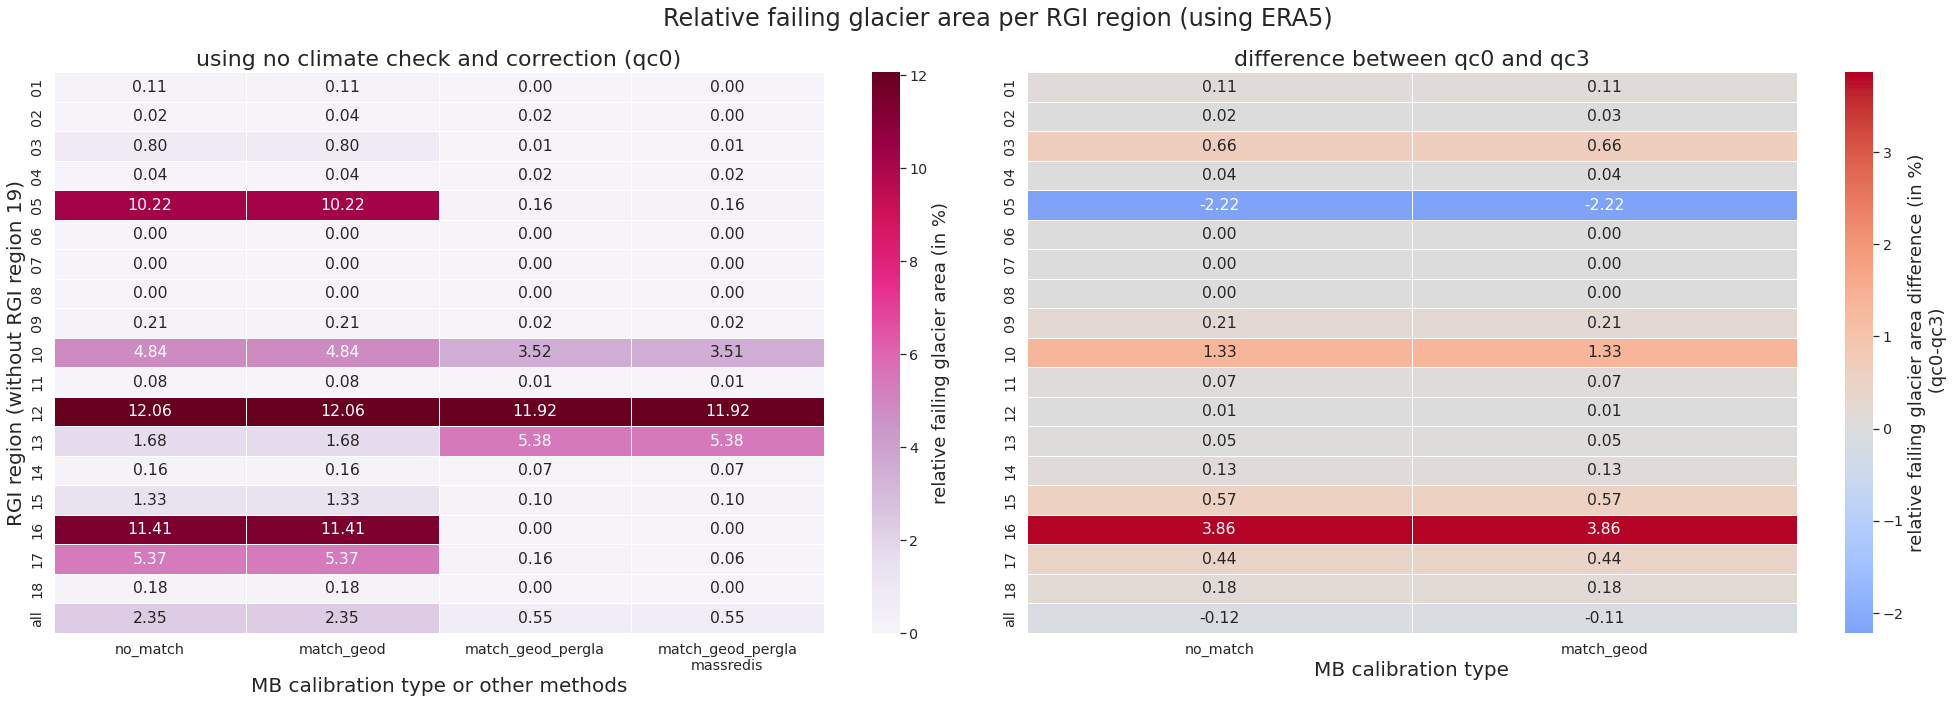

In [62]:
sns.set(font_scale = 1.3)
plt.figure(figsize=(28,10))
plt.suptitle(f'Relative failing glacier area per RGI region (using {clim})', fontsize=24)
plt.subplot(121)
plt.title('using no climate check and correction (qc0)', fontsize=22)
sns.heatmap(pd_rel_error_area_reg_qc0,
            linewidths=.5, cmap="PuRd", cbar_kws={'label':'relative failing glacier area (in %)'},
           annot=True, fmt=".2f")
ax = plt.gca()
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.set_ylabel('RGI region (without RGI region 19)', fontsize=20);
ax.set_xlabel('MB calibration type or other methods', fontsize=20)
plt.subplot(122)
plt.title('difference between qc0 and qc3', fontsize=22)

sns.heatmap(pd_rel_error_area_reg_qc0.drop(columns=['match_geod_pergla','match_geod_pergla\nmassredis']) - pd_rel_error_area_reg_qc3,
            linewidths=.5, cmap='coolwarm', 
            cbar_kws={'label':'relative failing glacier area difference (in %)\n (qc0-qc3)'},
           annot=True,center=0, fmt=".2f")
ax = plt.gca()
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.set_ylabel('');
ax.set_xlabel('MB calibration type', fontsize=20)

plt.tight_layout()

- `no_match` and `match_geod` have almost the same amount of relative failing glacier area
- with `qc0`, most relative glacier area fails in:
    - RGI region 5, 16, 17, 10 (descending order) with more MB calibration errors if using the no_match or match_geod options!
    - RGI region 12 mostly from missing outlines of nominal glaciers
    - RGI region 13 if using the match_geod_pergla method (no mu* could be found even when correcting the climate, which happens in that case for both qc0 and qc3!)
- differences between qc0 and qc3:
    - only in RGI region 5 (Greenland) more glaciers fail when using qc3, but RGI region 5 is the RGI region with the largest glacier area!!!
    - for all other RGI regions, more glaciers fail with qc0 (specifically for RGI region 16 & 10, where there are more MB calibration errors for qc0 than for qc3)

**Let's also estimate the regional missing area for the W5E5 preprocessed gdirs:**

In [64]:
for match, pcp in zip(['match_geod_pergla_winterprcp', 'match_geod_pergla_2.6'],['via_winterprcp', '2.6']):
    for rgi_reg in np.arange(0,21,1):
        if 0<rgi_reg <10:
            rgi_reg = f'0{rgi_reg}'
        elif rgi_reg == 0:
            rgi_reg = 'all_without_19'
        elif rgi_reg == 20:
            rgi_reg = 'all'
        else:
            rgi_reg = str(rgi_reg)
        dfserr_reg, pd_rel_error_area_reg = error_analysis_w_plot(dfserr=dfserr_reg, pd_rel_error_area=pd_rel_error_area_reg, rename_match=True,
                  level='L5', exp='elev_bands', pcp = pcp,
                      match =match, clim='GSWP3_W5E5', 
                      qc = 'qc0', border = 160,
                      rgi_reg = rgi_reg, 
                      path = '/home/www/fmaussion/runs/new_gdirs/oggm_v1.6/', subplot = False, xlim=None, plot=False)

19
19


In [65]:
pd_rel_error_area_reg

rel_error_area_in_percent  \
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_all_without_19                         2.345166   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_01                                     0.114866   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_02                                      0.01733   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_03                                     0.799821   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_04                                     0.039192   
...                                                                                       ...   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_16                   0.064843   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_17                   4.867621   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_18                        0.0   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_19                   0.211799   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_all                  0.810195   

                                                                    level  \
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_all_without_19           L5   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_01                       L5   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_02                       L5   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_03                       L5   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_04                       L5   
...                                                                   ...   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_16     L5   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_17     L5   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_18     L5   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_19     L5   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_all    L5   

                                                                            exp  \
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_all_without_19         elev_bands   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_01                     elev_bands   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_02                     elev_bands   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_03                     elev_bands   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_04                     elev_bands   
...                                                                         ...   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_16   elev_bands   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_17   elev_bands   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_18   elev_bands   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_19   elev_bands   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_all  elev_bands   

                                                                           clim_pcp  \
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_all_without_19             CRU_pcp2.5   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_01                         CRU_pcp2.5   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_02                         CRU_pcp2.5   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_03                         CRU_pcp2.5   
L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_04                         CRU_pcp2.5   
...                                                                             ...   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_16   GSWP3_W5E5_2.6   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_17   GSWP3_W5E5_2.6   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_18   GSWP3_W5E5_2.6   
L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_19   GSWP3_W5E5_2.6   
L5_elev_bands_2.6_GSWP3_

In [79]:
_g_stats_W5E5_cte['m_star_glacierwide'].dropna()

0       561.749772
1       564.601981
2       561.905215
3       584.397095
4       538.729916
           ...    
2747    381.330360
2748    156.925992
2749    552.939853
2750    496.680765
2751    471.011642
Name: mu_star_glacierwide, Length: 2343, dtype: float64

In [104]:
### get the prcp. factor distributions for every RGI region 

pd_glac_stats_all_d = {}
pd_clim_stats_all_d = {}
for clim_p in ['CRU_pcp2.5', 'ERA5_pcp1.6', 'W5E5_pcp2.6', 'W5E5_pcp_via\nwinterprcp']:
    _g_stats_l = []
    _c_stats_l = []
    if clim_p == 'CRU_pcp2.5':
        rgi_regs = np.arange(1,19,1)
    else:
        rgi_regs = np.arange(1,20,1)
    for rgi_reg in rgi_regs:
        if 0<rgi_reg <10:
            rgi_reg = f'0{rgi_reg}'
        else:
            rgi_reg = str(rgi_reg)
        if clim_p == 'W5E5_pcp_via\nwinterprcp':
            _g_stats = pd.read_csv(f'/home/www/fmaussion/runs/new_gdirs/oggm_v1.6/L3-L5_files/GSWP3_W5E5/elev_bands/qc0/match_geod_pergla_winterprcp/RGI62/b_160/L5/summary/glacier_statistics_{rgi_reg}.csv')#[['glacier_prcp_scaling_factor']]
            _c_stats = pd.read_csv(f'/home/www/fmaussion/runs/new_gdirs/oggm_v1.6/L3-L5_files/GSWP3_W5E5/elev_bands/qc0/match_geod_pergla_winterprcp/RGI62/b_160/L5/summary/climate_statistics_{rgi_reg}.csv')#[['glacier_prcp_scaling_factor']]

        elif clim_p == 'W5E5_pcp2.6':
            _g_stats = pd.read_csv(f'/home/www/fmaussion/runs/new_gdirs/oggm_v1.6/L3-L5_files/GSWP3_W5E5/elev_bands/qc0/match_geod_pergla_2.6/RGI62/b_160/L5/summary/glacier_statistics_{rgi_reg}.csv')#[['glacier_prcp_scaling_factor']]
            _c_stats = pd.read_csv(f'/home/www/fmaussion/runs/new_gdirs/oggm_v1.6/L3-L5_files/GSWP3_W5E5/elev_bands/qc0/match_geod_pergla_2.6/RGI62/b_160/L5/summary/climate_statistics_{rgi_reg}.csv')#[['glacier_prcp_scaling_factor']]

        elif clim_p == 'CRU_pcp2.5':
            _g_stats = pd.read_csv(f'/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/CRU/elev_bands/qc0/pcp2.5/match_geod_pergla/RGI62/b_080/L5/summary/glacier_statistics_{rgi_reg}.csv')#[['glacier_prcp_scaling_factor']]
            _c_stats = pd.read_csv(f'/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/CRU/elev_bands/qc0/pcp2.5/match_geod_pergla/RGI62/b_080/L5/summary/climate_statistics_{rgi_reg}.csv')#[['glacier_prcp_scaling_factor']]

        elif clim_p == 'ERA5_pcp1.6':
            _g_stats = pd.read_csv(f'/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/ERA5/elev_bands/qc0/pcp1.6/match_geod_pergla/RGI62/b_080/L5/summary/glacier_statistics_{rgi_reg}.csv')#[['glacier_prcp_scaling_factor']]
            _c_stats = pd.read_csv(f'/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/ERA5/elev_bands/qc0/pcp1.6/match_geod_pergla/RGI62/b_080/L5/summary/climate_statistics_{rgi_reg}.csv')#[['glacier_prcp_scaling_factor']]



        _g_stats_l.append(_g_stats)
        _c_stats_l.append(_c_stats)


    pd_glac_stats_all = pd.concat(_g_stats_l)
    pd_clim_stats_all = pd.concat(_c_stats_l)

    pd_glac_stats_all.index = pd_glac_stats_all.rgi_id
    pd_clim_stats_all.index = pd_clim_stats_all.rgi_id

    pd_glac_stats_all_d[clim_p] = pd_glac_stats_all.loc[pd_glac_stats_all['mu_star_glacierwide'].dropna().index]
    pd_clim_stats_all_d[clim_p] = pd_clim_stats_all.loc[pd_glac_stats_all['mu_star_glacierwide'].dropna().index]


### get winter prcp. (back from prcp. fac. )
pd_glac_stats_all = pd_glac_stats_all_d['W5E5_pcp_via\nwinterprcp']
prcp_fac_dist = pd_glac_stats_all['glacier_prcp_scaling_factor']#####.values
winter_prcp_factor_ab = -1.0614, 3.9200
winter_prcp_factor_range = 0.1, 10
a, b = winter_prcp_factor_ab  # cfg.PARAMS['winter_prcp_factor_ab']
r0, r1 = winter_prcp_factor_range  # cfg.PARAMS['winter_prcp_factor_range']
assert np.all(prcp_fac_dist < r1)
assert np.all(prcp_fac_dist > r0)
w_prcp = np.exp((prcp_fac_dist - b)/a)
pd_glac_stats_all.loc[w_prcp.index, 'winter_prcp'] = w_prcp.values


pd_glac_stats_all['glacier_prcp_scaling_factor'].quantile([0,0.5, 1])



#pd_rel_error_area_reg_qc0

0.0    0.871099
0.5    3.639807
1.0    8.454943
Name: glacier_prcp_scaling_factor, dtype: float64

In [67]:
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg[pd_rel_error_area_reg.qc == 'qc0']
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.loc[(pd_rel_error_area_reg_qc0.border == 160) | (pd_rel_error_area_reg_qc0.clim_pcp == 'CRU_pcp2.5')|(pd_rel_error_area_reg_qc0.clim_pcp == 'ERA5_pcp1.6')] # only have border 80 for CRU ... 
pd_rel_error_area_reg_qc0.index = pd_rel_error_area_reg_qc0['rgi_reg']
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.loc[pd_rel_error_area_reg_qc0.match == 'match_geod_pergla']
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0[['rel_error_area_in_percent','clim_pcp']]
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.pivot(columns=['clim_pcp'])
pd_rel_error_area_reg_qc0.columns = pd_rel_error_area_reg_qc0.columns.droplevel(0)
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.astype("float32")
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.rename({'all_without_19':'all_no19'})

#### Comparison of relative failing glacier area for different climate datasets & W5E5 variable prcp. factor distributions

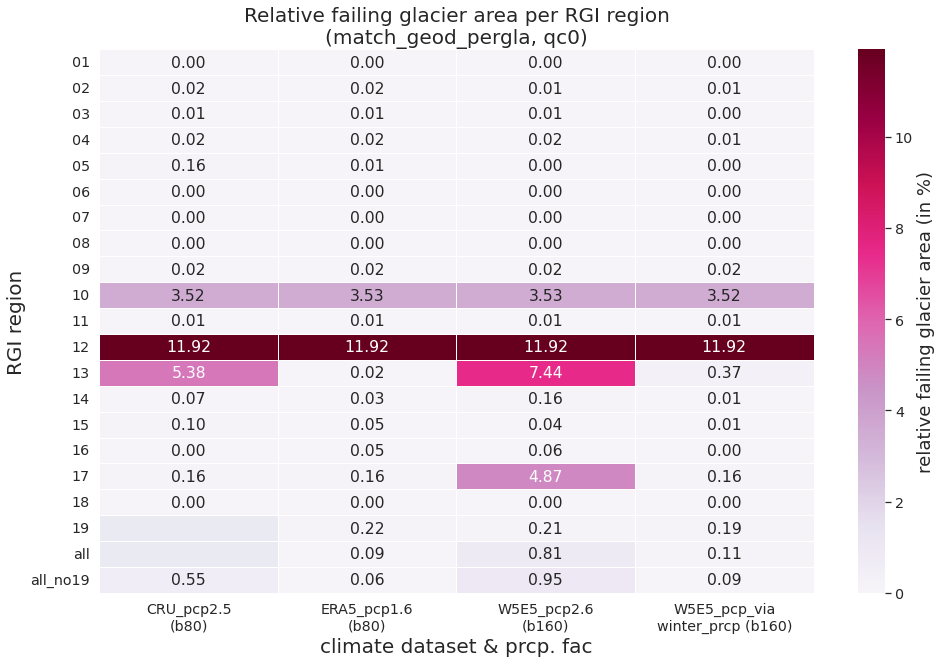

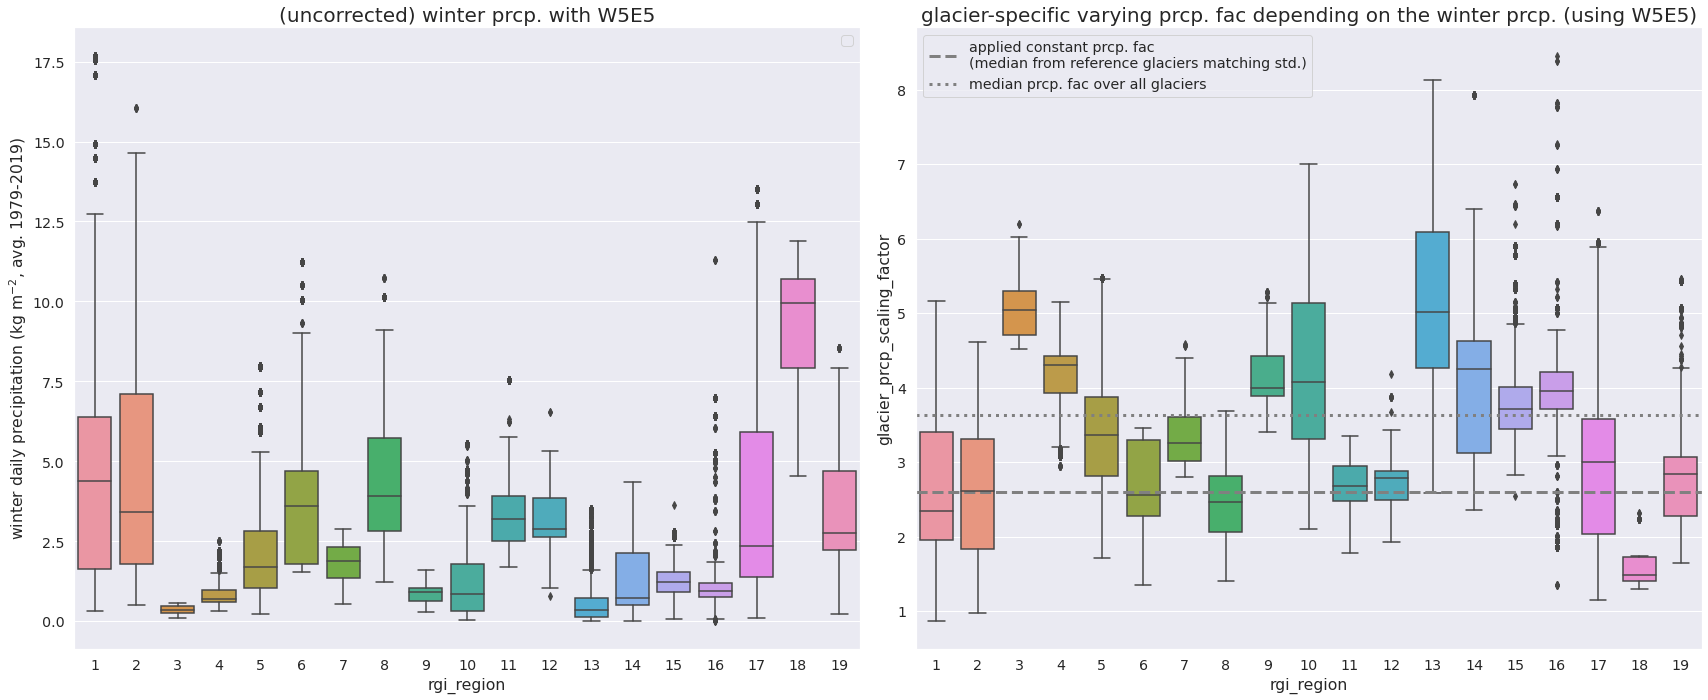

In [68]:
sns.set(font_scale = 1.3)
plt.figure(figsize=(16,10))
plt.subplot(111)
plt.title('Relative failing glacier area per RGI region\n(match_geod_pergla, qc0)', fontsize=20)
#plt.title(', fontsize=22)
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.round(2)
sns.heatmap(pd_rel_error_area_reg_qc0,
            linewidths=.5, cmap="PuRd", cbar_kws={'label':'relative failing glacier area (in %)'},
           annot=True, fmt=".2f")
ax = plt.gca()
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.set_ylabel('RGI region', fontsize=20);
ax.set_xticklabels(['CRU_pcp2.5\n(b80)', 'ERA5_pcp1.6\n(b80)', 'W5E5_pcp2.6\n(b160)', 'W5E5_pcp_via\nwinter_prcp (b160)'])
ax.set_xlabel('climate dataset & prcp. fac', fontsize=20)
plt.savefig('relative_failing_glacier_area_regional_match_geod_pergla_clim_pcp.png')

plt.figure(figsize=(24,10))
plt.subplot(122)
ax = plt.gca()
sns.boxplot(x = 'rgi_region', y='glacier_prcp_scaling_factor', data = pd_glac_stats_all, ax = ax)
plt.axhline(2.6, ls= '--', lw = 3, color = 'grey', label = 'applied constant prcp. fac\n(median from reference glaciers matching std.)')
plt.axhline(pd_glac_stats_all['glacier_prcp_scaling_factor'].quantile([0.5]).values,
            ls= ':', lw = 3, color = 'gray', label = 'median prcp. fac over all glaciers')
plt.legend()
plt.title('glacier-specific varying prcp. fac depending on the winter prcp. (using W5E5)', fontsize=20)

plt.subplot(121)
ax = plt.gca()
sns.boxplot(x = 'rgi_region', y='winter_prcp', data = pd_glac_stats_all, ax = ax)

plt.legend()
plt.ylabel(r'winter daily precipitation (kg m$^{-2}$, avg. 1979-2019)')
plt.title('(uncorrected) winter prcp. with W5E5', fontsize=20)
plt.tight_layout()
plt.savefig('W5E5_prcp_fac_via_winterpcp_boxplots.png')


- When using a constant prcp. fac of 2.6 with W5E5, we have in most RGI regions, the same or more missing glacier area compared to CRU or ERA5
    - a larger failing glacier area occurs specifically for RGI region 13 & 17, and to a smaller extent RGI region 16
    - a slighlty smaller failing glacier area occurs for the largest RGI region 5 & for RGI region 19
- When using W5E5 together with a glacier-specific winter prcp. dependent prcp. fac, we have for all RGI regions the same or much less failing glacier area compared to the median prcp. fac W5E5 gdirs.
    - this effect is strongly visible for RGI regions 13 & 17: 
        - With W5E5 using a variable prcp. fac there is for RGI region 13 less failing glacier area compared to CRU or constant prcp. fac W5E5, but still more than when using ERA5. 
        - Glaciers in RGI13 have rather low amount of precipitation. When adding more prcp. to it by using a larger prcp. fac of ~5, less glaciers seem to fail. Probably in ERA5 more prcp. happens for RGI region 13? (similar as for CRU, mostly the glaciers that have positive observed MB can not be calibrated). 

-> **When comparing all datasets, the climate which results in the least amount of failing glacier area is still ERA5, but W5E5 that uses variable winter prcp. is similar (only slightly worse in RGI region 13 & 17).**

##### Comparison of ref_hgt_calib_diff


In [ ]:

plt.figure(figsize=(24,10))
plt.subplot(122)
ax = plt.gca()
sns.boxplot(x = 'rgi_region', y='ref_hgt_calib_diff', data = pd_glac_stats_all, ax = ax)
#plt.axhline(2.6, ls= '--', lw = 3, color = 'grey', label = '')
#plt.axhline(pd_glac_stats_all['glacier_prcp_scaling_factor'].quantile([0.5]).values,
#            ls= ':', lw = 3, color = 'gray', label = 'median prcp. fac over all glaciers')
#plt.legend()
#plt.title('glacier-specific varying prcp. fac depending on the winter prcp. (using W5E5)', fontsize=20)

#### Comparison of precipitation between the datasets

In [222]:
pd_glac_running = []
for clim_p in ['CRU_pcp2.5', 'ERA5_pcp1.6', 'W5E5_pcp2.6', 'W5E5_pcp_via\nwinterprcp']:
    pd_glac_running.append(pd_clim_stats_all_d[clim_p].index)
pd_glac_running_all= list(set(pd_glac_running[0]).intersection(pd_glac_running[1]).intersection(pd_glac_running[2]).intersection(pd_glac_running[3]))
_pd_prcp_l = []
for clim_p in ['CRU_pcp2.5', 'ERA5_pcp1.6', 'W5E5_pcp2.6', 'W5E5_pcp_via\nwinterprcp']:

    _pd_prcp = pd.DataFrame()
    _pd_prcp['rgi_id'] = pd_glac_running_all
    _pd_prcp['1980-2010_avg_prcp'] = pd_clim_stats_all_d[clim_p].loc[pd_glac_running_all]['1980-2010_avg_prcp'].values
    _pd_prcp['1980-2010_avg_prcpsol_mean_elev'] = pd_clim_stats_all_d[clim_p].loc[pd_glac_running_all]['1980-2010_avg_prcpsol_mean_elev'].values
    _pd_prcp['ref_hgt_calib_diff'] = pd_glac_stats_all_d[clim_p].loc[pd_glac_running_all]['ref_hgt_calib_diff'].values
    _pd_prcp['rgi_region'] =  pd_glac_stats_all_d[clim_p].loc[pd_glac_running_all]['rgi_region'].values
    # replace it by 0 for the statistics...
    _pd_prcp.loc[np.isnan(_pd_prcp['ref_hgt_calib_diff']), 'ref_hgt_calib_diff'] = 0
    _pd_prcp['clim_pcp'] = clim_p
    _pd_prcp['prcp_factor'] = 'corrected_prcp'

    _pd_prcp_l.append(_pd_prcp)
    
    if 'winterprcp' in clim_p:
        pcp = pd_glac_stats_all_d[clim_p].loc[pd_glac_running_all]['glacier_prcp_scaling_factor'].values
    else:
        pcp = float(clim_p[-3:])
    _pd_prcp_no_prcp_fac = pd.DataFrame()
    _pd_prcp_no_prcp_fac['rgi_id'] = pd_glac_running_all
    _pd_prcp_no_prcp_fac['1980-2010_avg_prcp'] = pd_clim_stats_all_d[clim_p].loc[pd_glac_running_all]['1980-2010_avg_prcp'].values/pcp
    _pd_prcp_no_prcp_fac['1980-2010_avg_prcpsol_mean_elev'] = pd_clim_stats_all_d[clim_p].loc[pd_glac_running_all]['1980-2010_avg_prcpsol_mean_elev'].values/pcp
    
    # just to have a nicer table, these things are the same
    _pd_prcp_no_prcp_fac['ref_hgt_calib_diff'] = pd_glac_stats_all_d[clim_p].loc[pd_glac_running_all]['ref_hgt_calib_diff'].values
    _pd_prcp_no_prcp_fac['rgi_region'] =  pd_glac_stats_all_d[clim_p].loc[pd_glac_running_all]['rgi_region'].values
    # replace it by 0 for the statistics...
    _pd_prcp_no_prcp_fac.loc[np.isnan(_pd_prcp_no_prcp_fac['ref_hgt_calib_diff']), 'ref_hgt_calib_diff'] = 0  
    _pd_prcp_no_prcp_fac['clim_pcp'] = clim_p

    _pd_prcp_no_prcp_fac['prcp_factor'] = 'uncorrected_prcp'

    _pd_prcp_l.append(_pd_prcp_no_prcp_fac)

pd_prcp = pd.concat(_pd_prcp_l)
pd_prcp = pd_prcp.reset_index()

In [223]:
pd_prcp

index          rgi_id  1980-2010_avg_prcp  \
0             0  RGI60-14.14686         1076.216437   
1             1  RGI60-13.15533         2024.289065   
2             2  RGI60-17.06667         2262.269807   
3             3  RGI60-13.27602          579.943412   
4             4  RGI60-13.20733         2288.944279   
...         ...             ...                 ...   
1666331  208287  RGI60-14.02150          153.039118   
1666332  208288  RGI60-02.10847          719.925040   
1666333  208289  RGI60-17.11974         1198.084835   
1666334  208290  RGI60-17.02434          595.221264   
1666335  208291  RGI60-04.07009          193.791625   

         1980-2010_avg_prcpsol_mean_elev  ref_hgt_calib_diff  rgi_region  \
0                             544.484230                 0.0          14   
1                            1815.313027                 0.0          13   
2                            1412.045519                 0.0          17   
3                             414.010951                 0.0          13   
4                            1840.195214                 0.0          13   
...                                  ...                 ...         ...   
1666331                       113.290625                 0.0          14   
1666332                       498.517150                 0.0           2   
1666333                       896.347553                 0.0          17   
1666334                       276.167502                 0.0          17   
1666335                       171.829744                 0.0           4   

                         clim_pcp       prcp_factor  
0                      CRU_pcp2.5    corrected_prcp  
1                      CRU_pcp2.5    corrected_prcp  
2                      CRU_pcp2.5    corrected_prcp  
3                      CRU_pcp2.5    corrected_prcp  
4                      CRU_pcp2.5    corrected_prcp  
...                           ...               ...  
1666331  W5E5_pcp_via\nwinterprcp  uncorrected_prcp  
1666332  W5E5_pcp_via\nwinterprcp  uncorrected_prcp  
1666333  W5E5_pcp_via\nwinterprcp  uncorrected_prcp  
1666334  W5E5_pcp_via\nwinterprcp  uncorrected_prcp  
1666335  W5E5_pcp_via\nwinterprcp  uncorrected_prcp  

[1666336 rows x 8 columns]

In [166]:
#sns.kdeplot(x='1980-2010_avg_prcp', hue='clim_pcp', data = pd_prcp, log_scale=True) #[['clim_pcp', '1980-2010_avg_prcp']])

<AxesSubplot:xlabel='1980-2010_avg_prcpsol_mean_elev', ylabel='Density'>

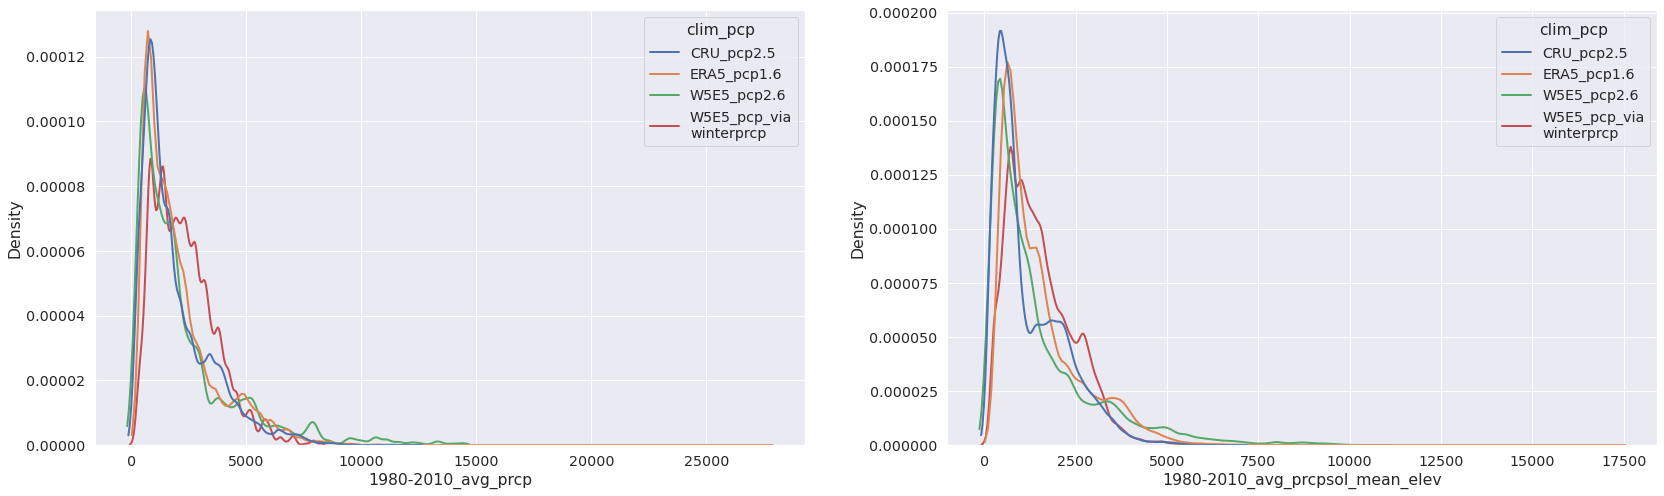

In [183]:
fig, axs = plt.subplots(1,2, figsize=(28,8))
sns.kdeplot(x='1980-2010_avg_prcp', hue='clim_pcp', data = pd_prcp, cut = True, lw = 2, ax = axs[0]) #[['clim_pcp', '1980-2010_avg_prcp']])
sns.kdeplot(x='1980-2010_avg_prcpsol_mean_elev', hue='clim_pcp', data = pd_prcp, cut = True, ax = axs[1], lw=2) #[['clim_pcp', '1980-2010_avg_prcp']])

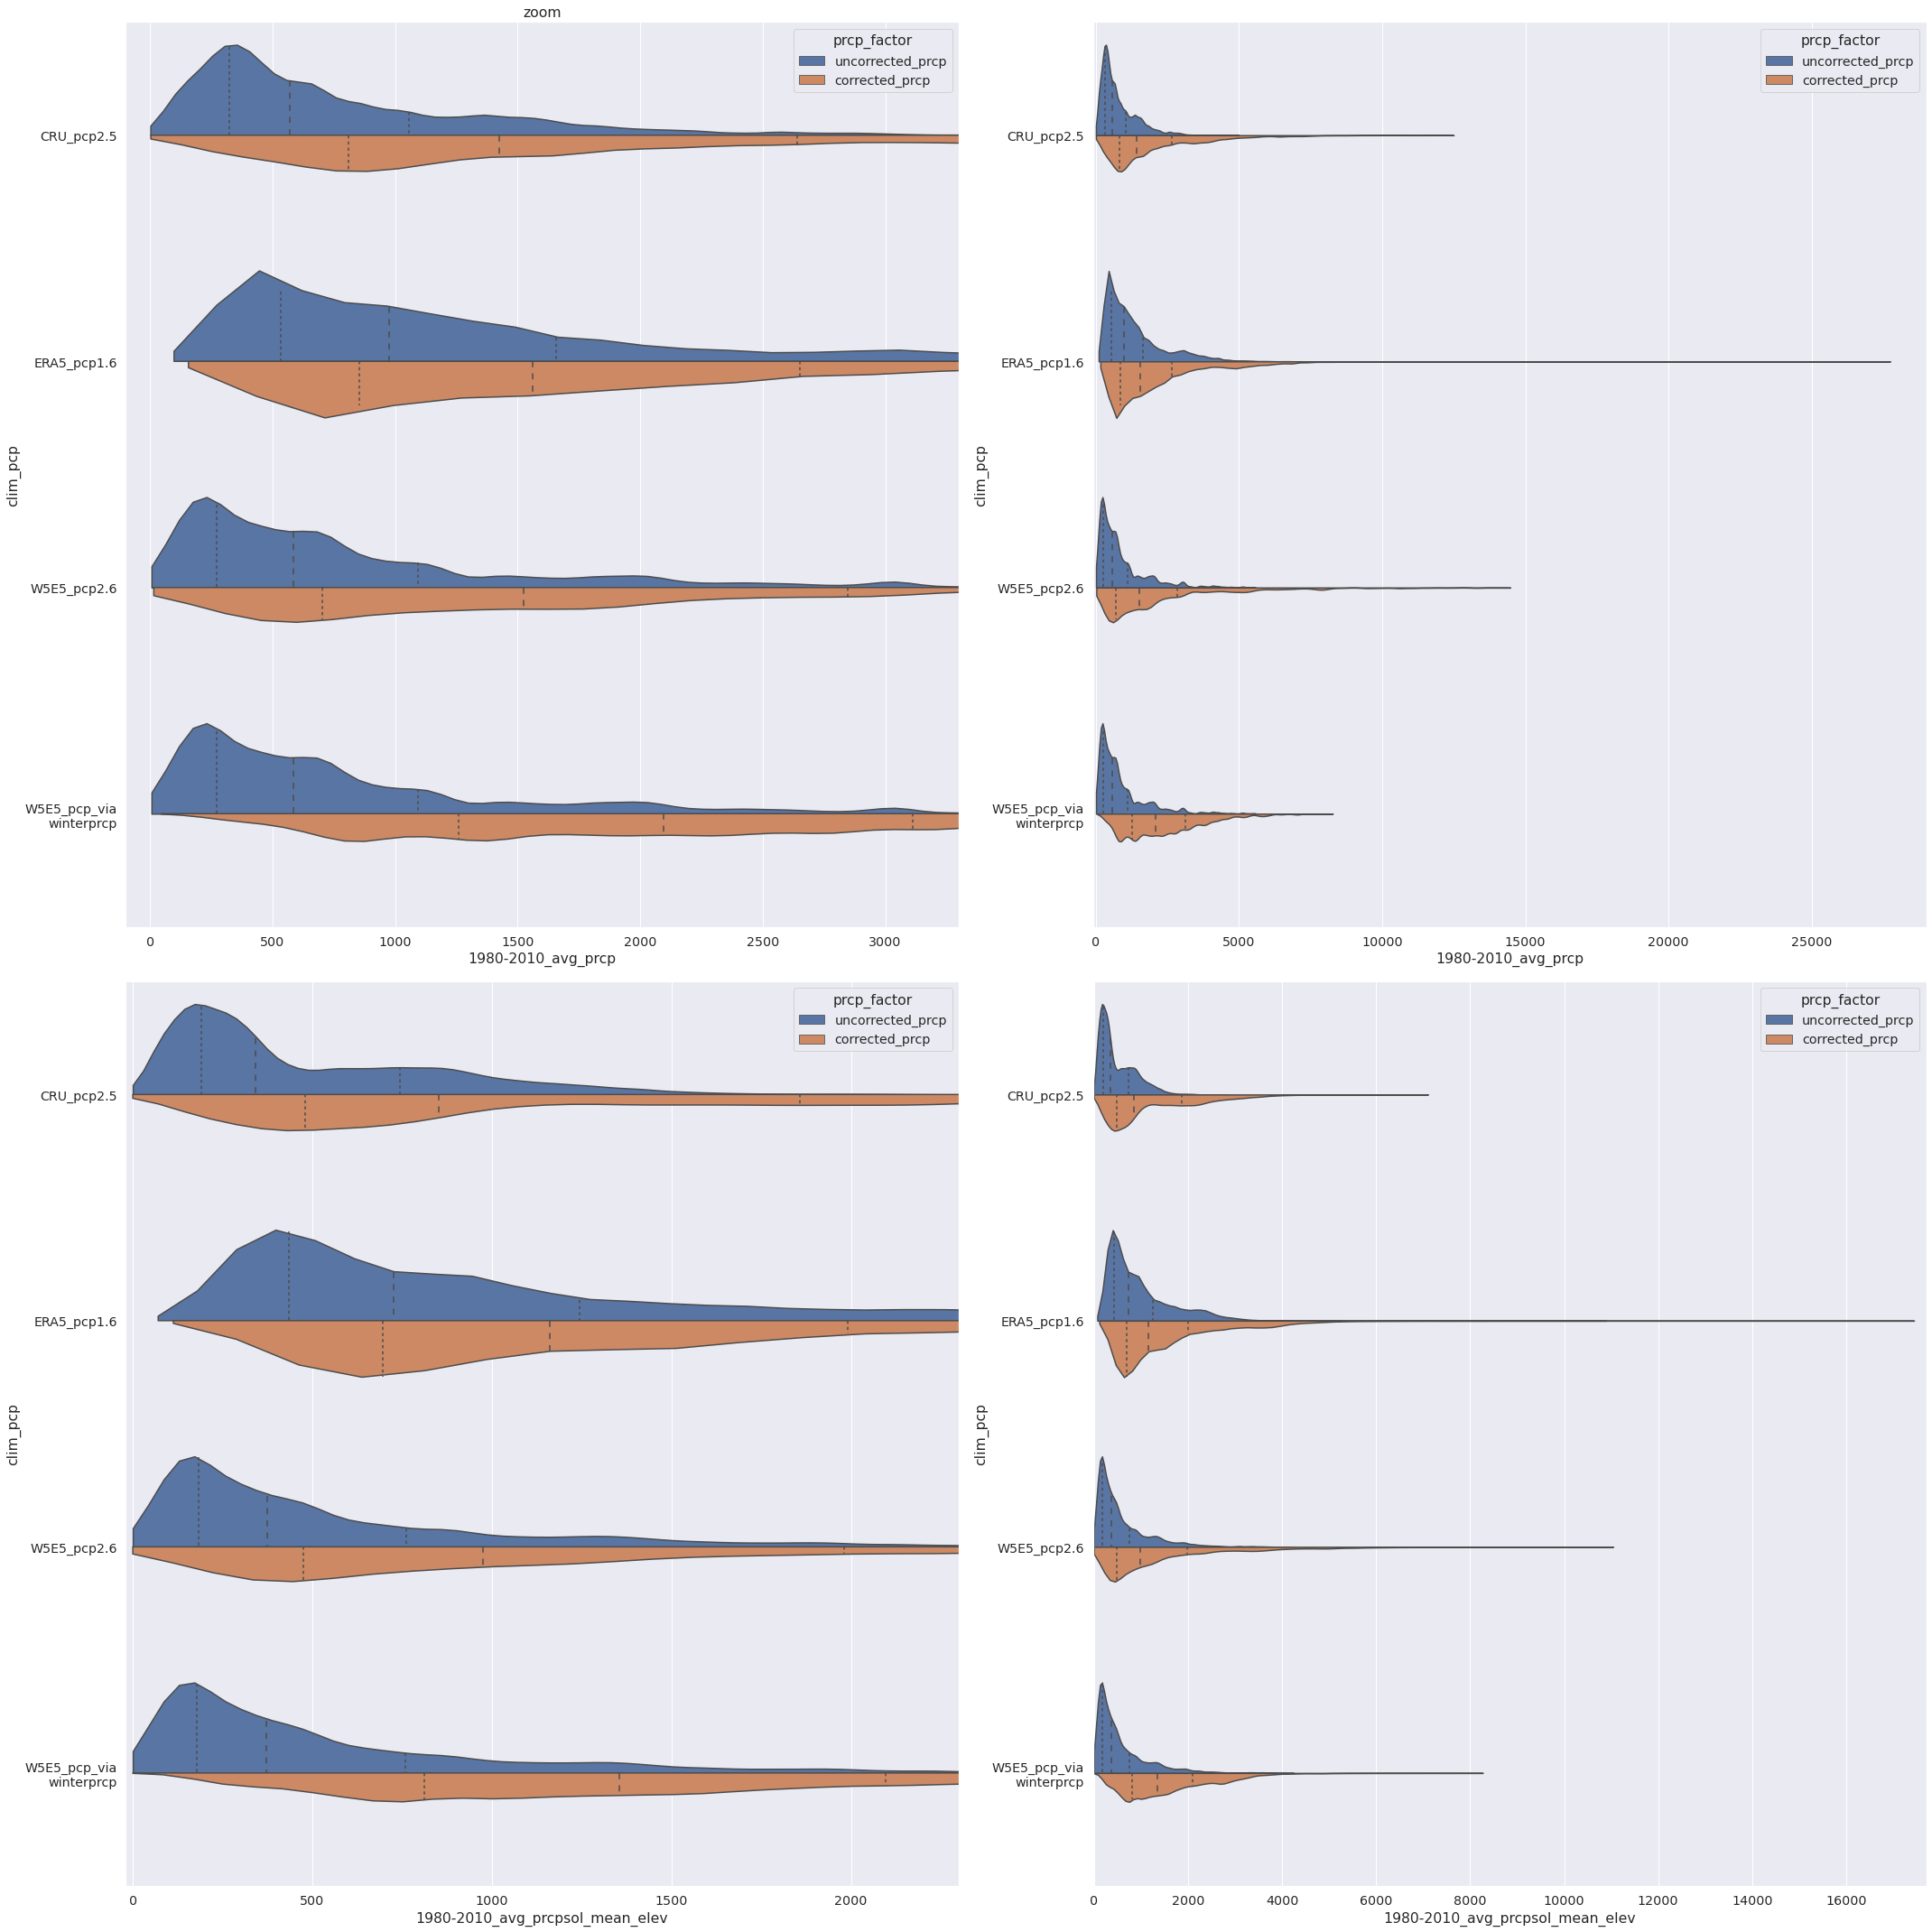

In [237]:
hue_order = ['uncorrected_prcp', 'corrected_prcp']
fig, axs = plt.subplots(2,2, figsize=(30,30))
sns.violinplot(x='1980-2010_avg_prcp', y='clim_pcp', data = pd_prcp, cut = 0, inner='quartile', lw = 2, split = True, hue='prcp_factor',hue_order =hue_order,
              ax = axs[0][0]) #[['clim_pcp', '1980-2010_avg_prcp']])
axs[0][0].set_xlim([-100,3300])
axs[0][0].set_title('zoom')
sns.violinplot(x='1980-2010_avg_prcp', y='clim_pcp', data = pd_prcp, cut = 0, inner='quartile', lw = 2, split = True, hue='prcp_factor',hue_order =hue_order,
              ax = axs[0][1]) #[['clim_pcp', '1980-2010_avg_prcp']])
axs[0][1].set_xlim([-100,29000])

sns.violinplot(x='1980-2010_avg_prcpsol_mean_elev', y='clim_pcp', data = pd_prcp, cut = 0, inner = 'quartile', split = True, hue='prcp_factor',hue_order =hue_order,
              ax = axs[1][0]) #[['clim_pcp', '1980-2010_avg_prcp']])
axs[1][0].set_xlim([-20,2300])
sns.violinplot(x='1980-2010_avg_prcpsol_mean_elev', y='clim_pcp', data = pd_prcp, cut = 0, inner = 'quartile', split = True, hue='prcp_factor',hue_order =hue_order,
              ax = axs[1][1]) #[['clim_pcp', '1980-2010_avg_prcp']])
axs[1][1].set_xlim([-20,17700])
plt.tight_layout()
plt.savefig('global_glacier_prcp_distributions.png')

(-100.0, 3000.0)

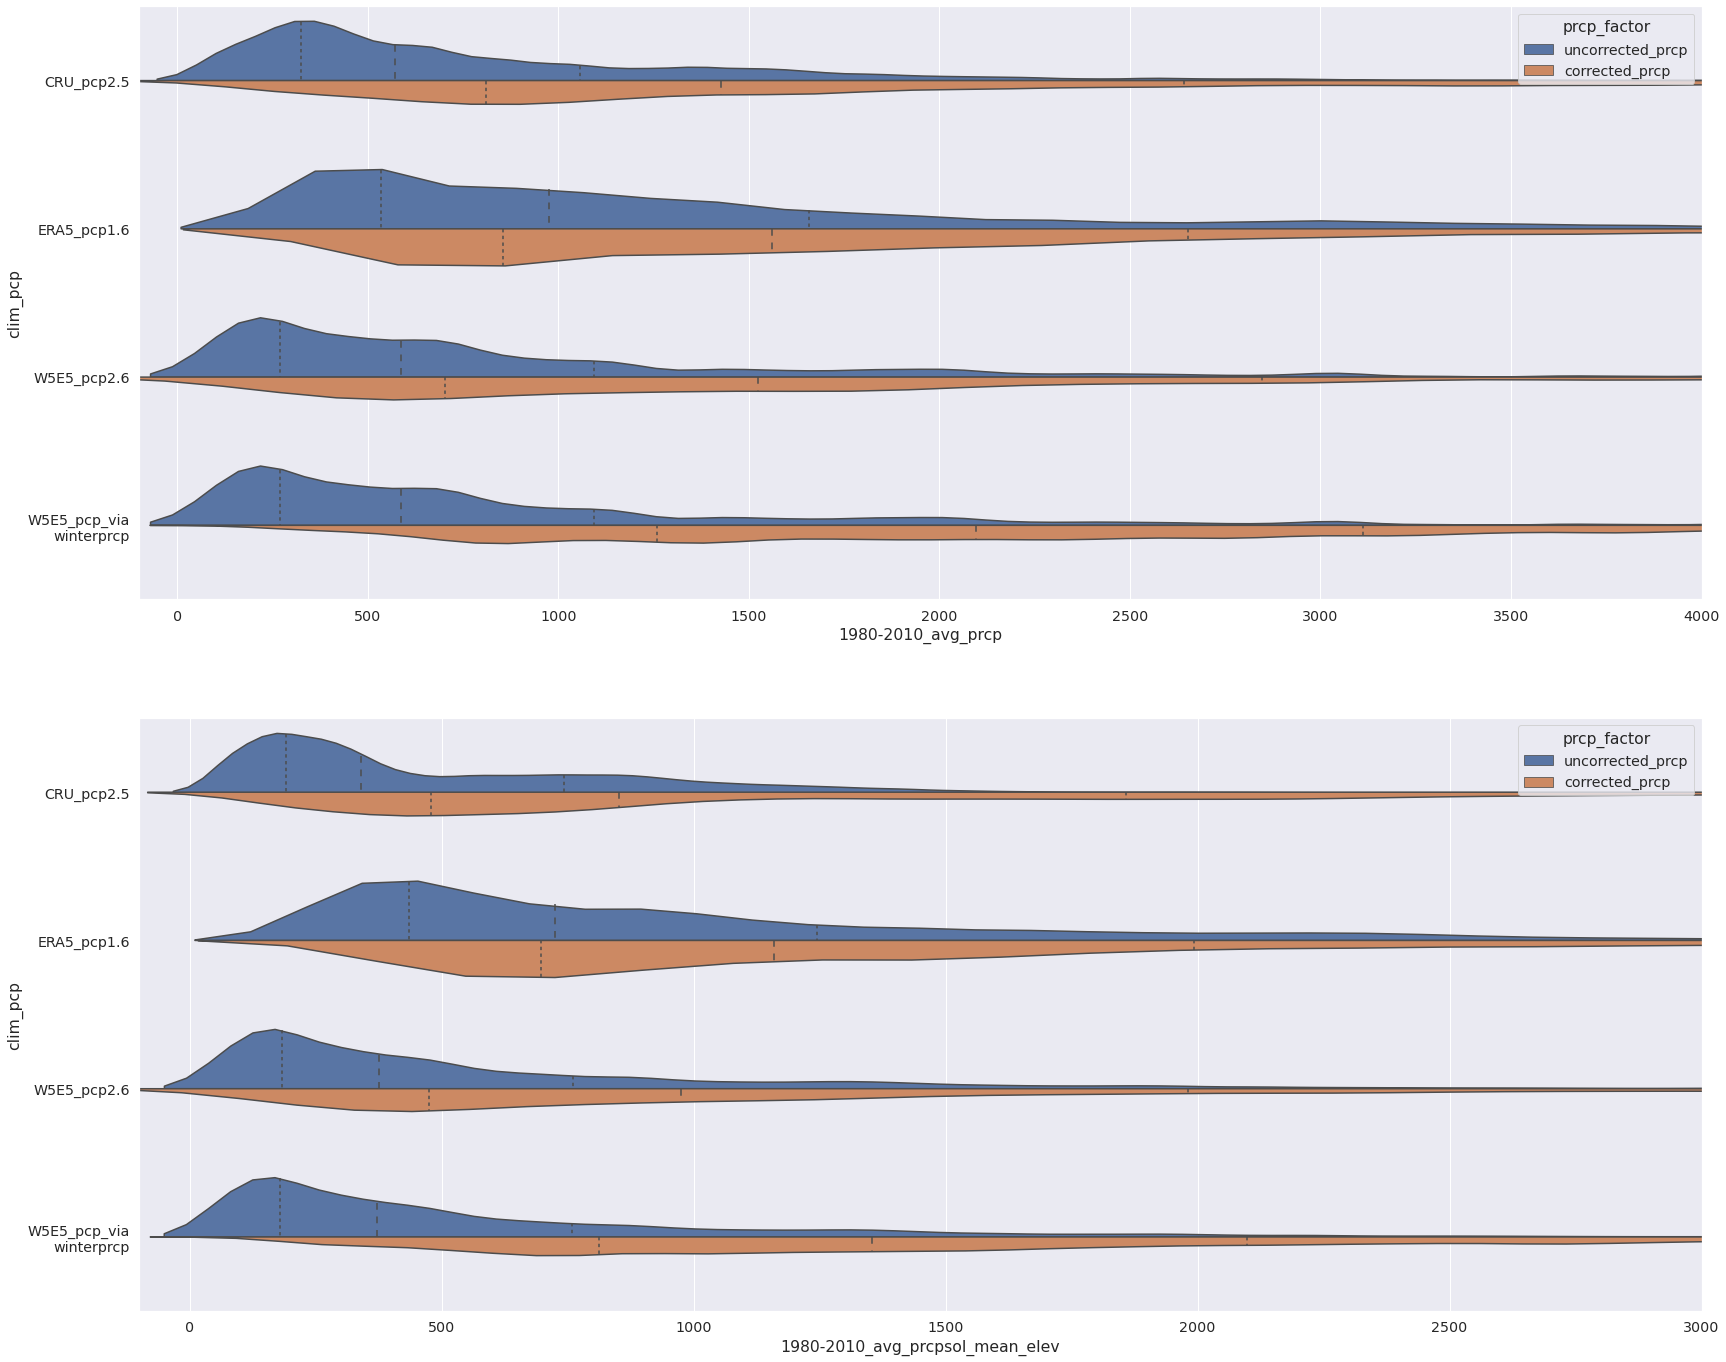

In [229]:
hue_order = ['uncorrected_prcp', 'corrected_prcp']
fig, axs = plt.subplots(2,1, figsize=(28,24))
sns.violinplot(x='1980-2010_avg_prcp', y='clim_pcp', data = pd_prcp, cut = True, inner='quartile', lw = 2, split = True, hue='prcp_factor',hue_order =hue_order,
              ax = axs[0]) #[['clim_pcp', '1980-2010_avg_prcp']])
axs[0].set_xlim([-100,4000])
sns.violinplot(x='1980-2010_avg_prcpsol_mean_elev', y='clim_pcp', data = pd_prcp, cut = True, inner = 'quartile', split = True, hue='prcp_factor',hue_order =hue_order,
              ax = axs[1]) #[['clim_pcp', '1980-2010_avg_prcp']])
axs[1].set_xlim([-100,3000])


In [ ]:
sns.catplot(x='ref_hgt_calib_diff', y='clim_pcp', data = pd_prcp, #cut = True, lw = 2,
            kind='boxen',  aspect=2) #[['clim_pcp', '1980-2010_avg_prcp']])

In [250]:
pd_prcp['applied temp. bias\nref_hgt_calib_diff * -0.0065'] = pd_prcp['ref_hgt_calib_diff']*-0.0065 

In [258]:
pd_prcp.groupby('clim_pcp').quantile([0.025, 0.975])['applied temp. bias\nref_hgt_calib_diff * -0.0065']

clim_pcp                       
CRU_pcp2.5                0.025   -1.462500
                          0.975    2.437500
ERA5_pcp1.6               0.025   -3.737206
                          0.975    0.000000
W5E5_pcp2.6               0.025   -2.437500
                          0.975    3.575000
W5E5_pcp_via\nwinterprcp  0.025   -2.762500
                          0.975    1.462500
Name: applied temp. bias\nref_hgt_calib_diff * -0.0065, dtype: float64

In [254]:
pd_prcp.groupby('clim_pcp').mean()['applied temp. bias\nref_hgt_calib_diff * -0.0065']

clim_pcp
CRU_pcp2.5                  0.082267
ERA5_pcp1.6                -0.336441
W5E5_pcp2.6                 0.121195
W5E5_pcp_via\nwinterprcp   -0.099101
Name: applied temp. bias\nref_hgt_calib_diff * -0.0065, dtype: float64

In [275]:
xr.open_dataset('/home/users/lschuster/www_lschuster/isimip3b/isimip3b_tasAdjust_std_monthly/ukesm1-0-ll_r1i1p1f2_w5e5_ssp585_tasAdjust_std_global_monthly_2015_2100.nc')

<xarray.Dataset>
Dimensions:        (time: 1032, lon: 720, lat: 360)
Coordinates:
  * time           (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2100-12-01
  * lon            (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
Data variables:
    tasAdjust_std  (time, lat, lon) float32 ...
Attributes: (12/24)
    title:                     ISIMIP3b bias-adjusted climate input data
    institution:               Potsdam Institute for Climate Impact Research ...
    contact:                   ISIMIP cross-sectoral science team <info@isimi...
    summary:                   CMIP6 daily output data bias-adjusted and stat...
    project:                   isimip3b
    product:                   input
    ...                        ...
    creation_date:             2021-05-13T20:28:04Z
    licence:                   CC0 1.0
    description:               UKESM1-0-LL bias corrected impact model input ...
    postprocessing_date:       2021-05-22
    postprocessing_scientist:  lilian.schuster@student.uibk.ac.at
    postprocessing_actions:    using xarray: ds = xr.open_mfdataset(isimip3b/...

Text(0.5, 1.0, '90% intervals in grey')

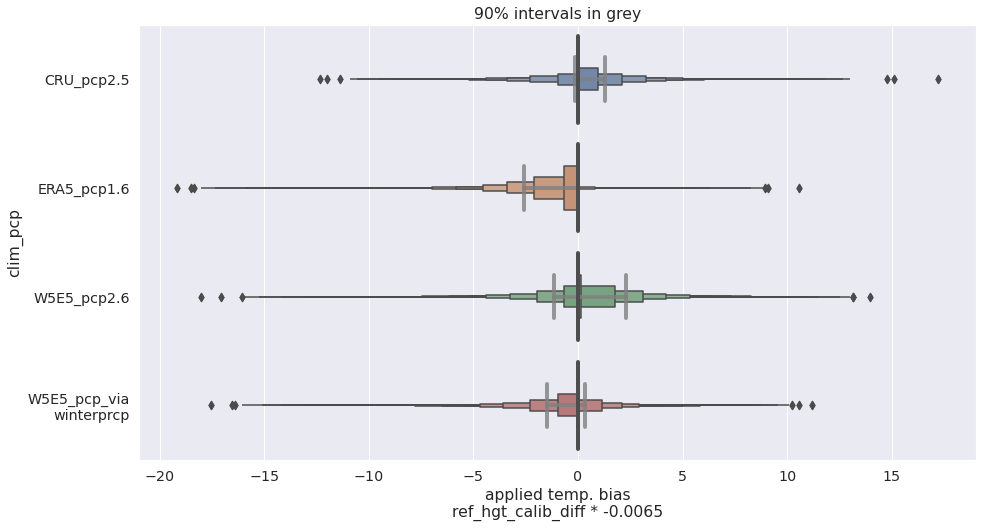

In [276]:
plt.subplots(1,1,figsize=(15,8))
ax = plt.gca()
sns.boxenplot(x='applied temp. bias\nref_hgt_calib_diff * -0.0065', y='clim_pcp',
               data = pd_prcp,
              saturation=0.6,
              ax=ax) 
sns.boxplot(x='applied temp. bias\nref_hgt_calib_diff * -0.0065', y='clim_pcp',
               data = pd_prcp,
            #kind='boxen',  
            whis = [5,95], 
                    linewidth=4,
                    saturation=0.8,
                    capprops={'color':'grey', 'alpha':0.8},
                    whiskerprops={'color':'grey', 'alpha':0.8},
            fliersize=0, color = 'grey',
              ax=ax)
plt.title('90% intervals in grey')

In [ ]:
uncorrected:
ERA5 has the most  and W5E5 the least amount of prcp. over glacier regions
ERA5 has the most and W5E5 & CRU similar lower amount of solid prcp.
correcting with constant factor:
balances out most "global" differences for prcp. between CRU, ERA5, W5E5,
but differences remain in the corrected solid prcp. amount: even with larger prcp. correction factors, ERA5 has still considerably larger solid prcp. amounts.
correcting with variable prcp. fac (and mostly larger prcp. fac.) for W5E5:
results for most glaciers in even more total and solid prcp. than with ERA5_pcp1.6 (and CRU). But, for some glaciers ERA5 gives still more prcp.

Text(0.5, 12.84800000000002, 'ref_hgt_calib_diff\n reference - uncorrected height')

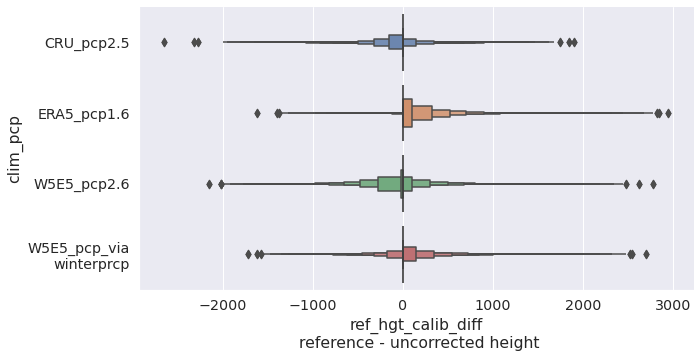

In [240]:
fig, axs= plt.subplot(1,1,figsize=(15,8))
sns.violinplot(x='ref_hgt_calib_diff', y='clim_pcp', data = pd_prcp, cut=0,#cut = True, lw = 2,
            kind='boxen',  axs) #[['clim_pcp', '1980-2010_avg_prcp']])
plt.gca().set_xlabel('ref_hgt_calib_diff\n reference - uncorrected height')
# if positive: the height is now higher, hence it is acting like reducing the temperature !!!

In [ ]:
sns.catplot(x='ref_hgt_calib_diff', y='clim_pcp', data = pd_prcp, #cut = True, lw = 2,
            col='rgi_region', kind='boxen', col_wrap=4, aspect=2) #[['clim_pcp', '1980-2010_avg_prcp']])

In [283]:
pd_prcp

index          rgi_id  1980-2010_avg_prcp  \
0             0  RGI60-14.14686         1076.216437   
1             1  RGI60-13.15533         2024.289065   
2             2  RGI60-17.06667         2262.269807   
3             3  RGI60-13.27602          579.943412   
4             4  RGI60-13.20733         2288.944279   
...         ...             ...                 ...   
1666331  208287  RGI60-14.02150          153.039118   
1666332  208288  RGI60-02.10847          719.925040   
1666333  208289  RGI60-17.11974         1198.084835   
1666334  208290  RGI60-17.02434          595.221264   
1666335  208291  RGI60-04.07009          193.791625   

         1980-2010_avg_prcpsol_mean_elev  ref_hgt_calib_diff  rgi_region  \
0                             544.484230                 0.0          14   
1                            1815.313027                 0.0          13   
2                            1412.045519                 0.0          17   
3                             414.010951                 0.0          13   
4                            1840.195214                 0.0          13   
...                                  ...                 ...         ...   
1666331                       113.290625                 0.0          14   
1666332                       498.517150                 0.0           2   
1666333                       896.347553                 0.0          17   
1666334                       276.167502                 0.0          17   
1666335                       171.829744                 0.0           4   

                         clim_pcp       prcp_factor  \
0                      CRU_pcp2.5    corrected_prcp   
1                      CRU_pcp2.5    corrected_prcp   
2                      CRU_pcp2.5    corrected_prcp   
3                      CRU_pcp2.5    corrected_prcp   
4                      CRU_pcp2.5    corrected_prcp   
...                           ...               ...   
1666331  W5E5_pcp_via\nwinterprcp  uncorrected_prcp   
1666332  W5E5_pcp_via\nwinterprcp  uncorrected_prcp   
1666333  W5E5_pcp_via\nwinterprcp  uncorrected_prcp   
1666334  W5E5_pcp_via\nwinterprcp  uncorrected_prcp   
1666335  W5E5_pcp_via\nwinterprcp  uncorrected_prcp   

         applied_temp_bias\nref_hgt_calib_diff * -0.0065  \
0                                                   -0.0   
1                                                   -0.0   
2                                                   -0.0   
3                                                   -0.0   
4                                                   -0.0   
...                                                  ...   
1666331                                             -0.0   
1666332                                             -0.0   
1666333                                             -0.0   
1666334                                             -0.0   
1666335                                             -0.0   

         applied temp. bias\nref_hgt_calib_diff * -0.0065  
0                                                    -0.0  
1                                                    -0.0  
2                                                    -0.0  
3                                                    -0.0  
4                                                    -0.0  
...                                                   ...  
1666331                                              -0.0  
1666332                                              -0.0  
1666333                                              -0.0  
1666334                                              -0.0  
1666335                                              -0.0  

[1666336 rows x 10 columns]

/home/users/lschuster/.local/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxenplot
  warnings.warn(msg, UserWarning)
/home/users/lschuster/.local/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, '90% intervals in grey')

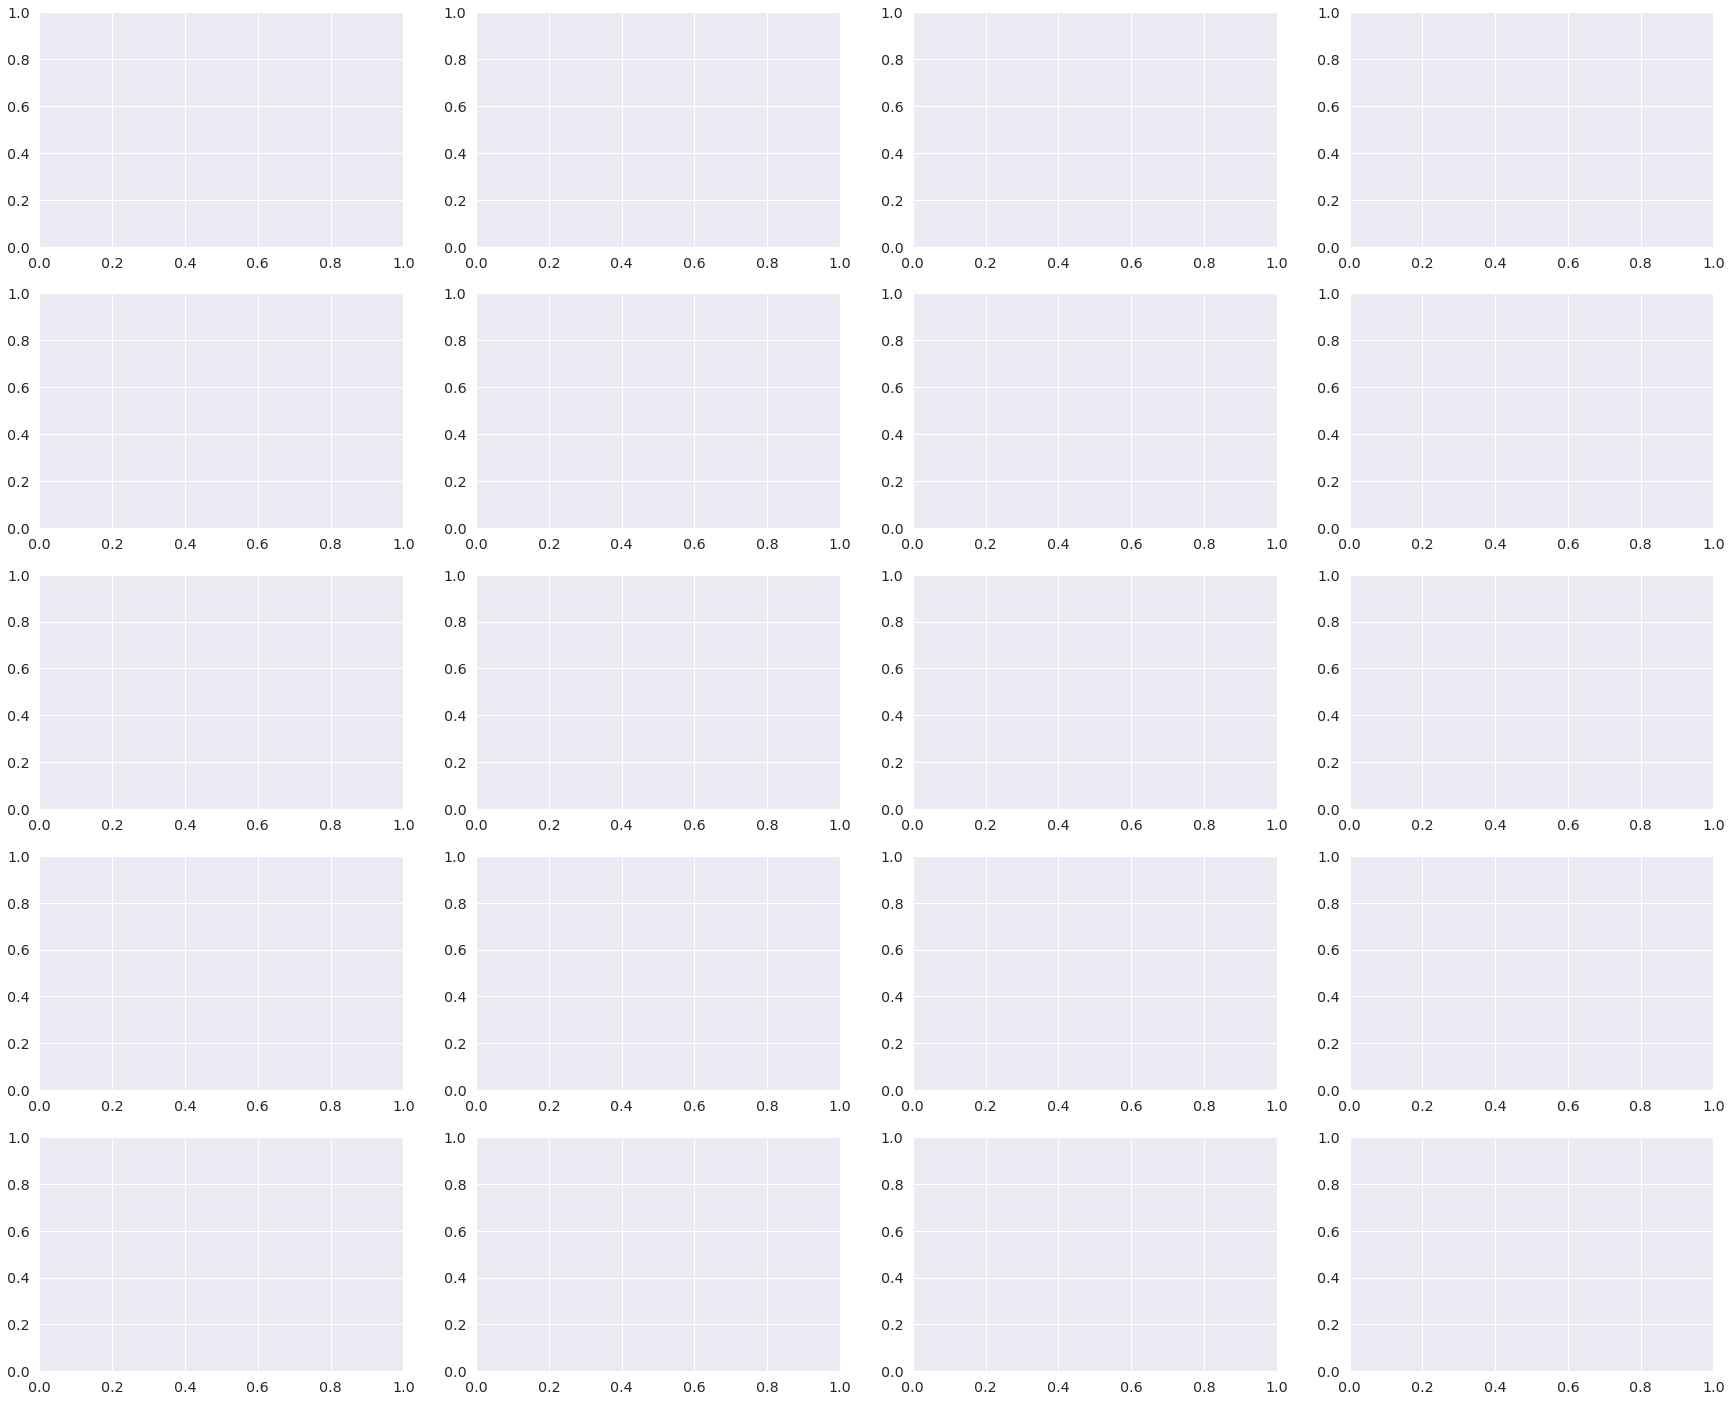

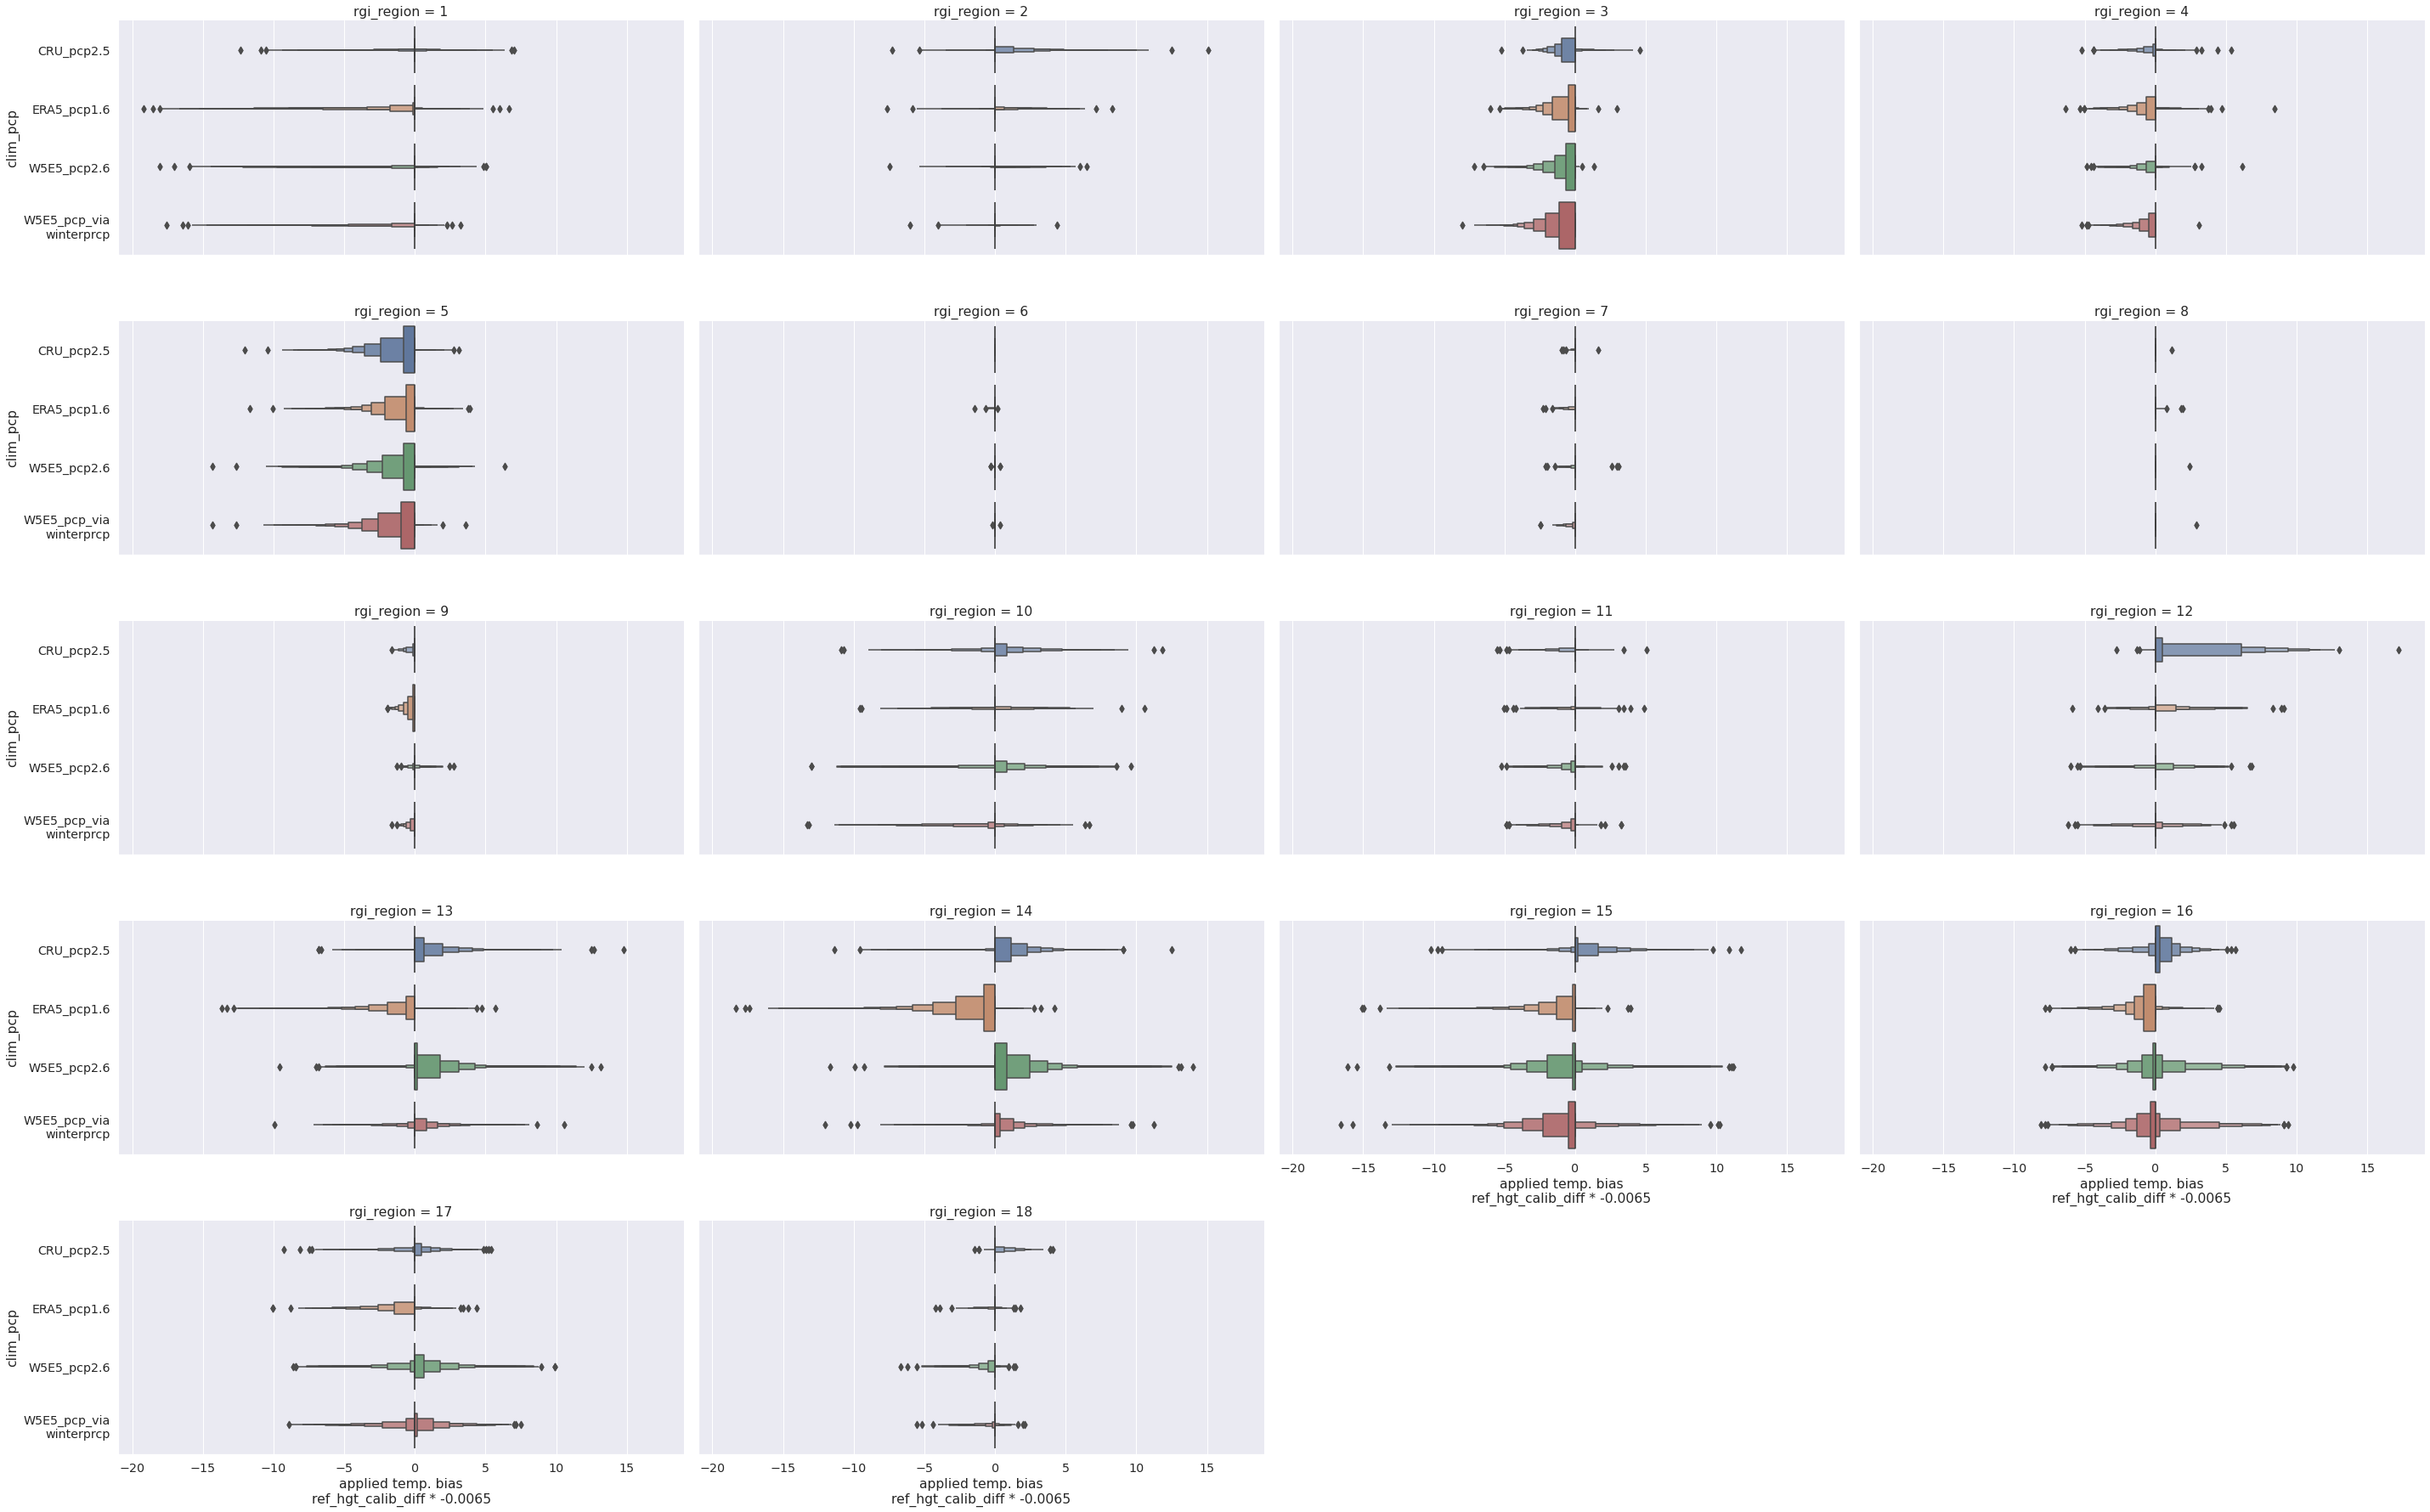

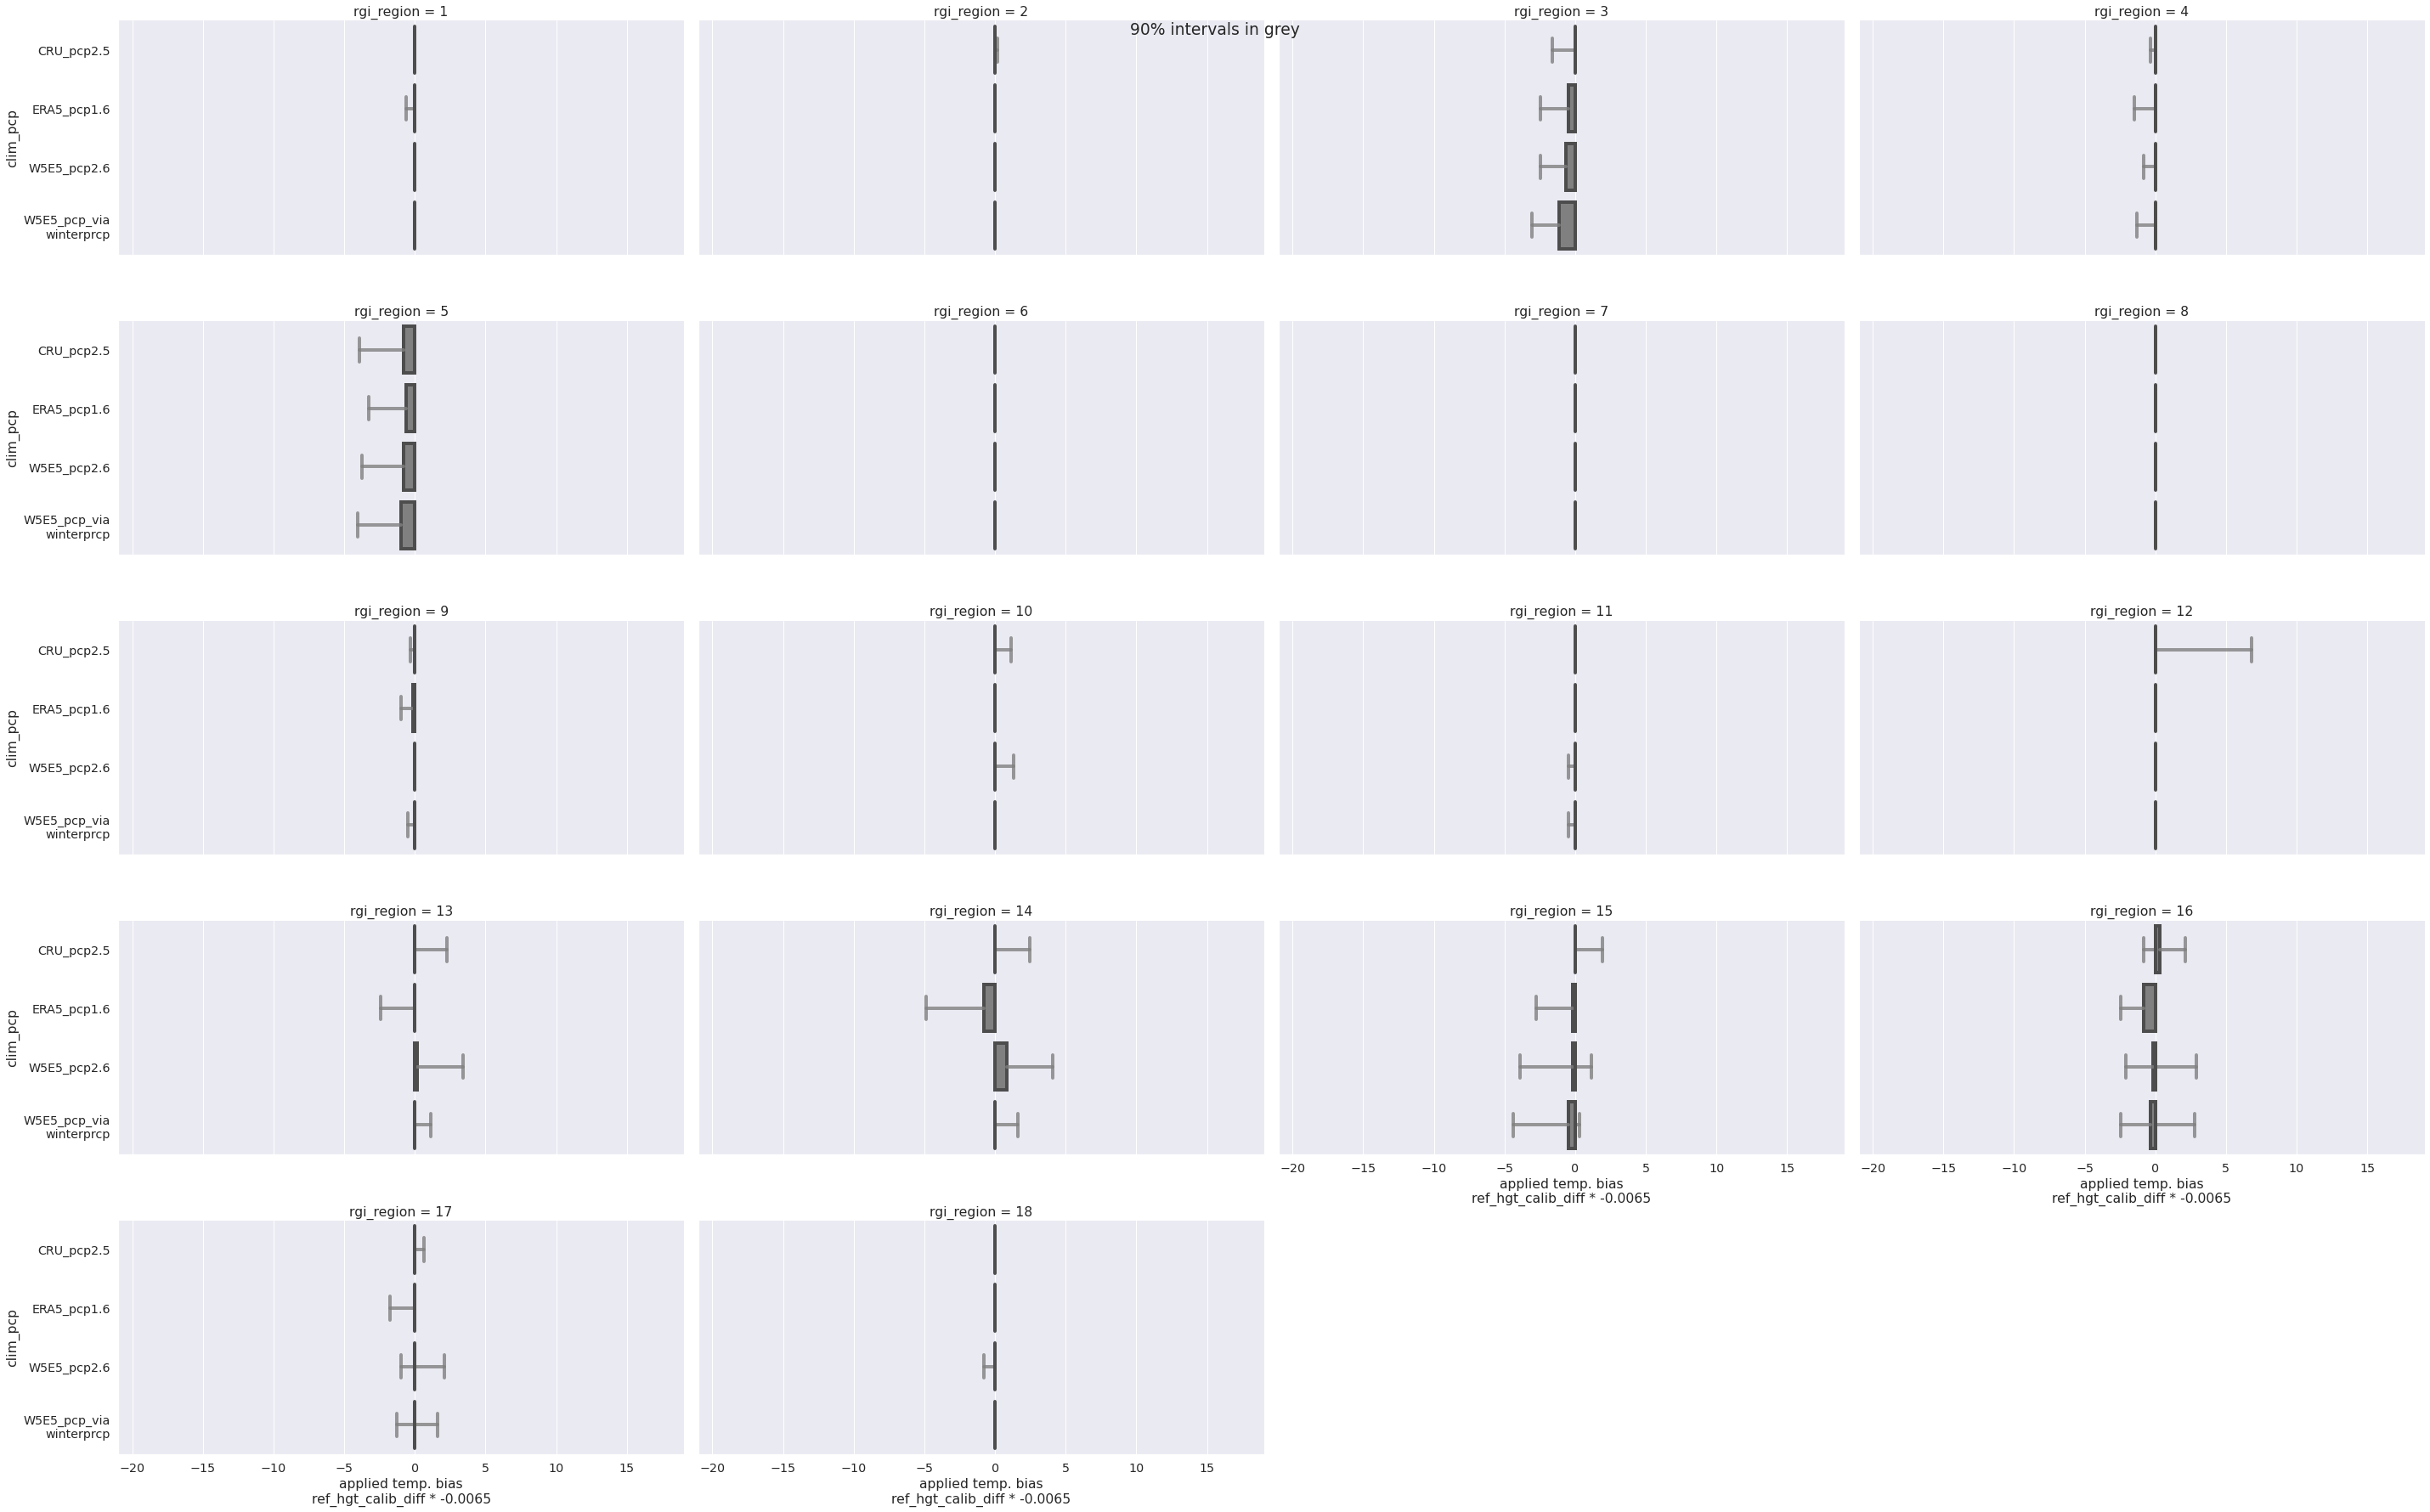

In [286]:
fig,axs=plt.subplots(5,4,figsize=(30,25))
#ax = plt.gca()
sns.catplot(x='applied temp. bias\nref_hgt_calib_diff * -0.0065', y='clim_pcp',
               data = pd_prcp, kind='boxen', col_wrap=4, aspect=2,col='rgi_region',
              saturation=0.6 #,ax=axs,
              ) 
sns.catplot(x='applied temp. bias\nref_hgt_calib_diff * -0.0065', y='clim_pcp',
               data = pd_prcp,kind='box', col_wrap=4, aspect=2,col='rgi_region',
            #kind='boxen',  
            whis = [5,95], 
                    linewidth=4,
                    saturation=0.8,
                    capprops={'color':'grey', 'alpha':0.8},
                    whiskerprops={'color':'grey', 'alpha':0.8},
            fliersize=0, color = 'grey',ax=axs,
              )
plt.suptitle('90% intervals in grey')

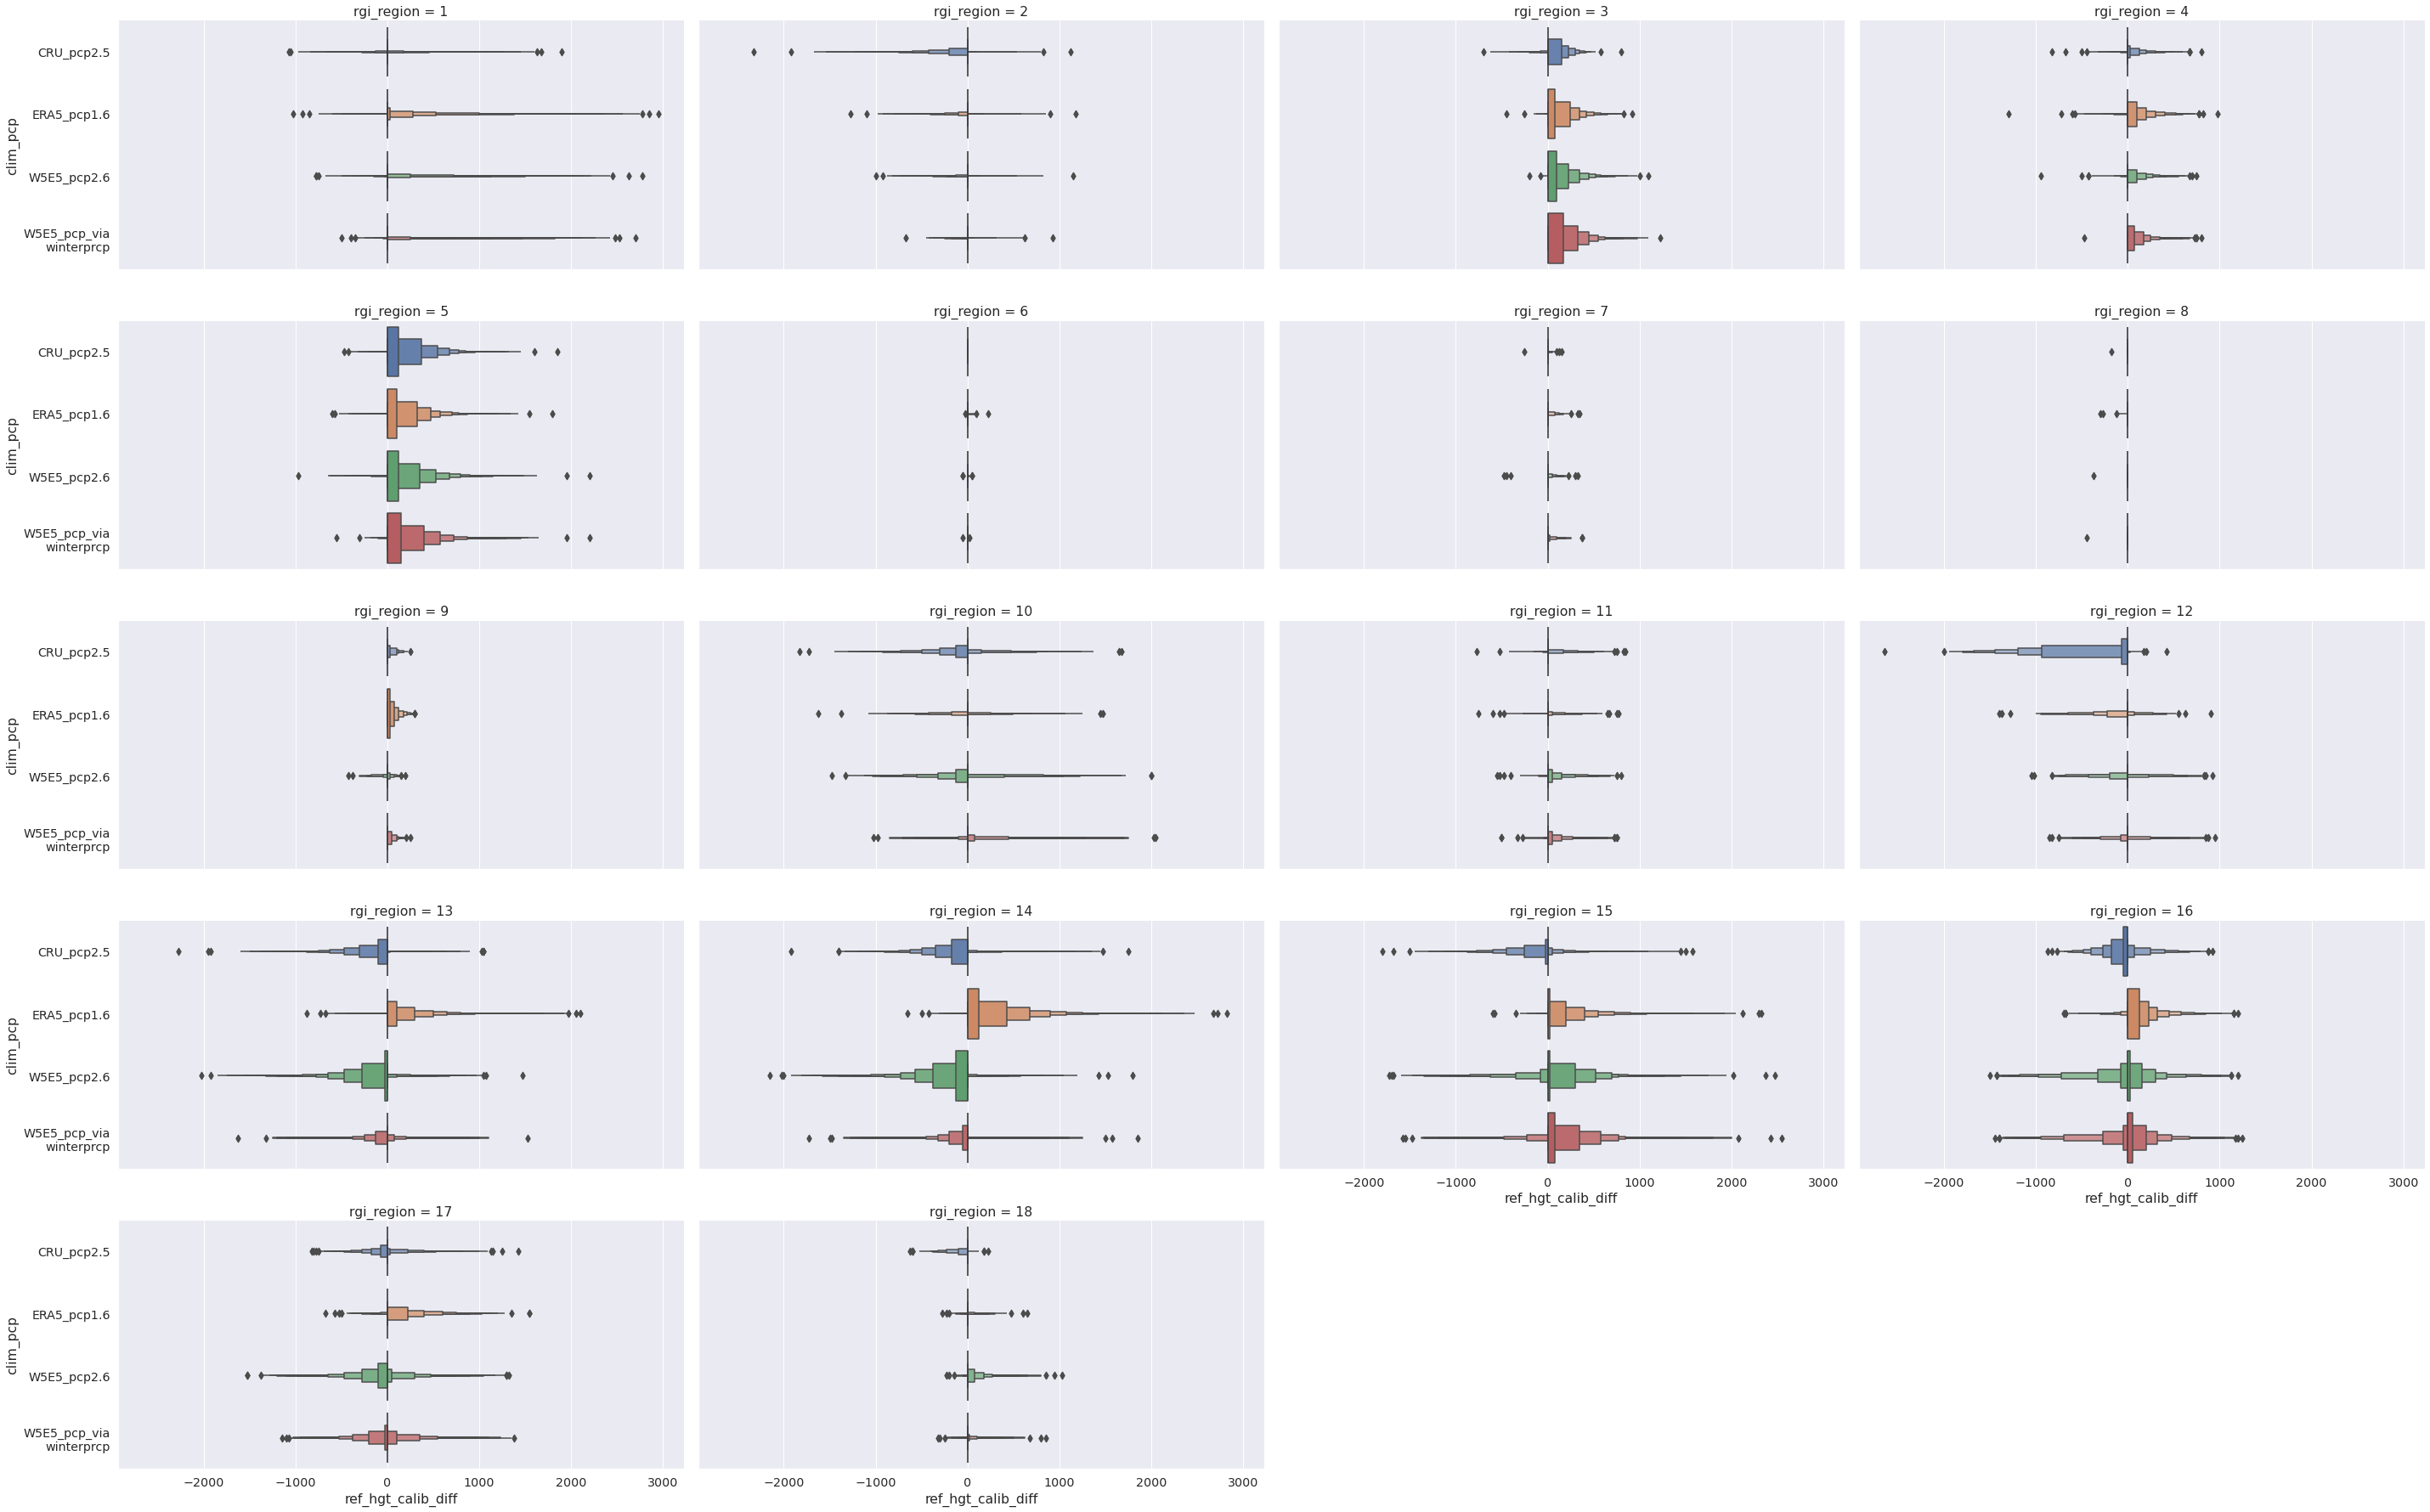

In [280]:
sns.catplot(x='ref_hgt_calib_diff', y='clim_pcp', data = pd_prcp, #cut = True, lw = 2,
            col='rgi_region', kind='boxen', col_wrap=4, aspect=2) #[['clim_pcp', '1980-2010_avg_prcp']])

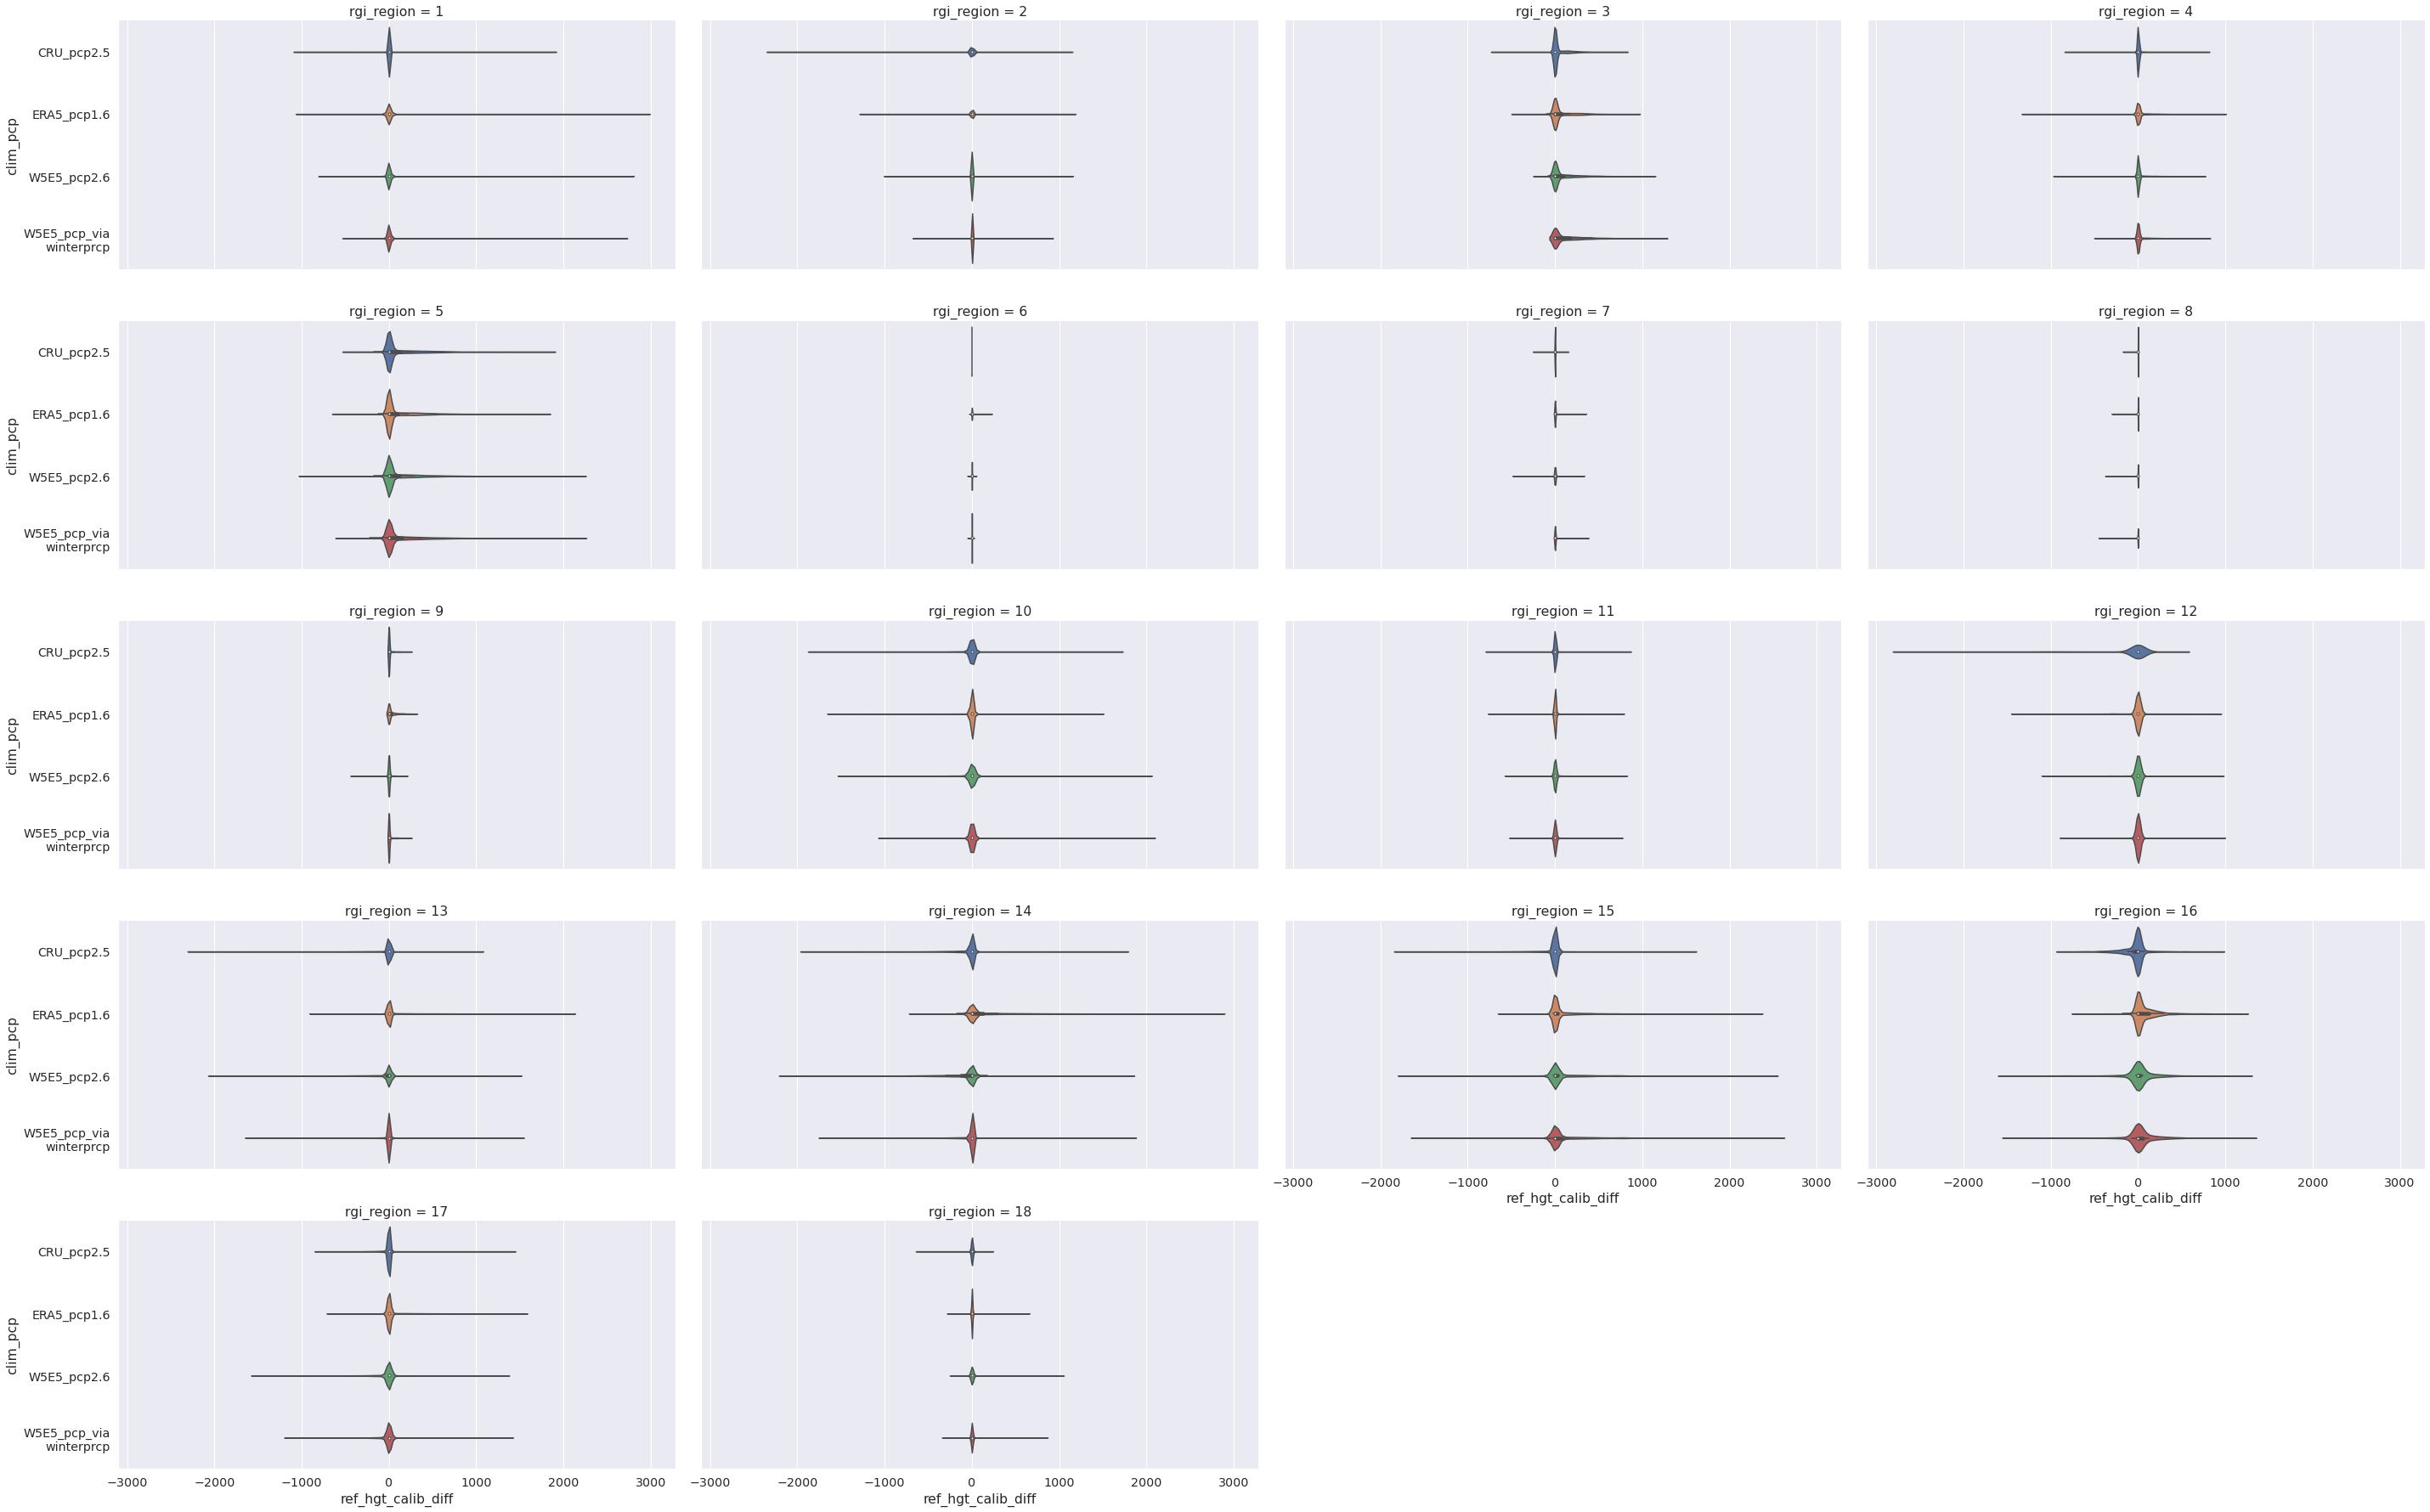

In [203]:
sns.catplot(x='ref_hgt_calib_diff', y='clim_pcp', data = pd_prcp, #cut = True, lw = 2,
            col='rgi_region', kind='violin', col_wrap=4, aspect=2) #[['clim_pcp', '1980-2010_avg_prcp']])

In [ ]:
pd_clim_stats_all_d['CRU_pcp2.5'][]
pd_glac_stats_all_d['CRU_pcp2.5'].columns
pd_glac_stats_all['ref_hgt_calib_diff'].dropna()

#### Some more regional checks, just to see the type of the error:

**RGI region 13 check**

- What is so specific in RGI region 13 that **match_geod_pergla** works less good using CRU specifically (more than twice as much errors and 3\*times as much area, see below) than when using the direct reference glacier calibration data (no_match)?
    - The problem is actually that precipitation is so low for these glaciers, that it can not reproduce the observed geodetic **positive** specific mass balance.

In [183]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13'].head()

rgi_area_km2                            error_task  \
rgi_id                                                               
RGI60-13.37825        51.478  mu_star_calibration_from_geodetic_mb   
RGI60-13.54059        42.521  mu_star_calibration_from_geodetic_mb   
RGI60-13.37587        32.259  mu_star_calibration_from_geodetic_mb   
RGI60-13.53668        29.870  mu_star_calibration_from_geodetic_mb   
RGI60-13.38833        27.602  mu_star_calibration_from_geodetic_mb   

                                                                                                                                     error_msg  
rgi_id                                                                                                                                          
RGI60-13.37825  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.54059  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.37587  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.53668  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.38833  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.

Text(0.5, 0, 'dmdtda')

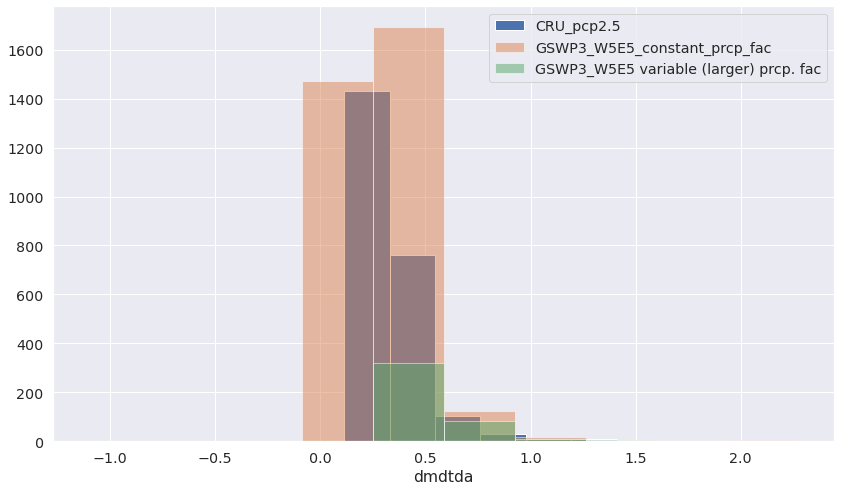

In [284]:
plt.hist(pd_geodetic.loc[dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13'].index].dmdtda,
        label='CRU_pcp2.5')
plt.hist(pd_geodetic.loc[dfserr_reg['L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_13'].index].dmdtda, alpha = 0.5, label = 'GSWP3_W5E5_constant_prcp_fac')
plt.hist(pd_geodetic.loc[dfserr_reg['L5_elev_bands_via_winterprcp_GSWP3_W5E5_match_geod_pergla_winterprcp_qc0_b160_rgi_13'].index].dmdtda,
         alpha = 0.5, label = 'GSWP3_W5E5 variable (larger) prcp. fac')
plt.legend()
plt.xlabel('dmdtda')


- all failing glaciers have a positive mass balance. This is the reason that glaciers are failing. 
    - maybe a larger precipitation factor for CRU would be necessary in this region specifically !!!
    - If we use instead ERA5 (see below), much less glaciers fail in this region!
    - Using a variable (and mostly) larger prcp. fac results in much less failing glaciers with W5E5. Then only those glaciers with larger positive dmdtda from the last 20 years are still failing

In [285]:
print('with match_geod_pergla:')
print(f"amount of glaciers failing in RGI 13: {len(dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13'])}")
print(f"failing glacier area in RGI 13:  {dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13'].rgi_area_km2.sum():0.1f} km2")

with match_geod_pergla:
amount of glaciers failing in RGI 13: 2357
failing glacier area in RGI 13:  2653.1 km2


In [286]:
# what are the glaciers failing for no match???
dfserr_reg['L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_13'].head()

rgi_area_km2    error_task  \
rgi_id                                       
RGI60-13.38733        30.849  local_t_star   
RGI60-13.38742        20.997  local_t_star   
RGI60-13.38768        18.447  local_t_star   
RGI60-13.38924        13.702  local_t_star   
RGI60-13.37368        13.572  local_t_star   

                                                                                     error_msg  
rgi_id                                                                                          
RGI60-13.38733  MassBalanceCalibrationError: RGI60-13.38733: mu* out of specified bounds: 3.57  
RGI60-13.38742  MassBalanceCalibrationError: RGI60-13.38742: mu* out of specified bounds: 4.26  
RGI60-13.38768  MassBalanceCalibrationError: RGI60-13.38768: mu* out of specified bounds: 4.19  
RGI60-13.38924  MassBalanceCalibrationError: RGI60-13.38924: mu* out of specified bounds: 4.51  
RGI60-13.37368  MassBalanceCalibrationError: RGI60-13.37368: mu* out of specified bounds: 2.67

In [287]:
print('with no_match:')
print(f"amount of glaciers failing in RGI 13: {len(dfserr_reg['L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_13'])}")
print(f"failing glacier area in RGI 13:  {dfserr_reg['L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_13'].rgi_area_km2.sum():0.1f} km2")

with no_match:
amount of glaciers failing in RGI 13: 1015
failing glacier area in RGI 13:  826.3 km2


Let's get a list of only those that fail for match_geod_pergla, but not for no_match!

In [288]:
rgi_fail_no_match = dfserr_reg['L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_13'].index
rgi_fail_match_geod_pergla = dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13'].index.values
rgi_fail_both = rgi_fail_no_match & rgi_fail_match_geod_pergla
pd_failing_rgi13_pergla = dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13']

/tmp/ipykernel_323319/3363420844.py:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  rgi_fail_both = rgi_fail_no_match & rgi_fail_match_geod_pergla


In [289]:
pd_failing_rgi13_pergla.drop(rgi_fail_both)

rgi_area_km2                            error_task  \
rgi_id                                                               
RGI60-13.37825        51.478  mu_star_calibration_from_geodetic_mb   
RGI60-13.54059        42.521  mu_star_calibration_from_geodetic_mb   
RGI60-13.37587        32.259  mu_star_calibration_from_geodetic_mb   
RGI60-13.53668        29.870  mu_star_calibration_from_geodetic_mb   
RGI60-13.38833        27.602  mu_star_calibration_from_geodetic_mb   
...                      ...                                   ...   
RGI60-13.52437         0.015  mu_star_calibration_from_geodetic_mb   
RGI60-13.51818         0.015  mu_star_calibration_from_geodetic_mb   
RGI60-13.52388         0.013  mu_star_calibration_from_geodetic_mb   
RGI60-13.52461         0.012  mu_star_calibration_from_geodetic_mb   
RGI60-13.52143         0.012  mu_star_calibration_from_geodetic_mb   

                                                                                                                                     error_msg  
rgi_id                                                                                                                                          
RGI60-13.37825  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.54059  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.37587  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.53668  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.38833  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
...                                                                                                                                        ...  
RGI60-13.52437  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.51818  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.52388  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.52461  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.52143  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  

[1860 rows x 3 columns]

It is not just one glacier that does not work with the match_geod_pergla method, but rather a lot of different mid-size glaciers. 

When using a varying prcp. fac, there are much less errors in region 13. We will have to check the prcp. fac distribution 

**RGI region 5 check**

In [290]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc0_b80_rgi_05'].head()

rgi_area_km2    error_task  \
rgi_id                                       
RGI60-05.10988       207.766  local_t_star   
RGI60-05.11001       182.955  local_t_star   
RGI60-05.10885       170.533  local_t_star   
RGI60-05.10615       167.934  local_t_star   
RGI60-05.11026       160.435  local_t_star   

                                                                                     error_msg  
rgi_id                                                                                          
RGI60-05.10988  MassBalanceCalibrationError: RGI60-05.10988: mu* out of specified bounds: 3.31  
RGI60-05.11001  MassBalanceCalibrationError: RGI60-05.11001: mu* out of specified bounds: 1.59  
RGI60-05.10885  MassBalanceCalibrationError: RGI60-05.10885: mu* out of specified bounds: 3.18  
RGI60-05.10615  MassBalanceCalibrationError: RGI60-05.10615: mu* out of specified bounds: 3.01  
RGI60-05.11026  MassBalanceCalibrationError: RGI60-05.11026: mu* out of specified bounds: 1.59

In [291]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_05'].head()

rgi_area_km2    error_task  \
rgi_id                                       
RGI60-05.10735       392.607  local_t_star   
RGI60-05.10634       388.067  local_t_star   
RGI60-05.10617       373.290  local_t_star   
RGI60-05.10762       309.061  local_t_star   
RGI60-05.10988       207.766  local_t_star   

                                                                                     error_msg  
rgi_id                                                                                          
RGI60-05.10735  MassBalanceCalibrationError: RGI60-05.10735: mu* out of specified bounds: 0.91  
RGI60-05.10634  MassBalanceCalibrationError: RGI60-05.10634: mu* out of specified bounds: 2.07  
RGI60-05.10617  MassBalanceCalibrationError: RGI60-05.10617: mu* out of specified bounds: 3.45  
RGI60-05.10762  MassBalanceCalibrationError: RGI60-05.10762: mu* out of specified bounds: 1.34  
RGI60-05.10988  MassBalanceCalibrationError: RGI60-05.10988: mu* out of specified bounds: 1.25

In [292]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_05']['error_msg'].iloc[0]

'MassBalanceCalibrationError: RGI60-05.10735: mu* out of specified bounds: 0.91'

In [293]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc0_b80_rgi_05'].rgi_area_km2.sum()

9165.776

In [294]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_05'].rgi_area_km2.sum()

11154.001

- around 20% more glacier area fails with qc3 in RGI reg 5 (with match_geod and CRU), because of bigger glaciers with MassBalanceCalibrationErrors!!!.

**RGI region 16 check**

In [295]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc0_b80_rgi_16'].head()

rgi_area_km2    error_task  \
rgi_id                                       
RGI60-16.01443        10.263  local_t_star   
RGI60-16.01473         7.372  local_t_star   
RGI60-16.00410         6.440  local_t_star   
RGI60-16.01483         5.482  local_t_star   
RGI60-16.01394         5.454  local_t_star   

                                                                                          error_msg  
rgi_id                                                                                               
RGI60-16.01443       MassBalanceCalibrationError: RGI60-16.01443: mu* out of specified bounds: 4.91  
RGI60-16.01473   MassBalanceCalibrationError: RGI60-16.01473: mu* out of specified bounds: 71516.08  
RGI60-16.00410       MassBalanceCalibrationError: RGI60-16.00410: mu* out of specified bounds: 0.84  
RGI60-16.01483  MassBalanceCalibrationError: RGI60-16.01483: mu* out of specified bounds: 109115.38  
RGI60-16.01394       MassBalanceCalibrationError: RGI60-16.01394: mu* out of specified bounds: 0.02

In [296]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc0_b80_rgi_16'].rgi_area_km2.sum()

267.156

In [297]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_16'].rgi_area_km2.sum()

176.732

- there is around 50% more failing glacier area for qc0 than for qc3 (with match_geod and CRU)

#####  RGI region 17 check

In [200]:
dfserr_reg['L5_elev_bands_2.6_GSWP3_W5E5_match_geod_pergla_2.6_qc0_b160_rgi_17'].head()

rgi_area_km2                            error_task  \
rgi_id                                                               
RGI60-17.05181      1234.714  mu_star_calibration_from_geodetic_mb   
RGI60-17.04982        61.974  mu_star_calibration_from_geodetic_mb   
RGI60-17.04963        40.424  mu_star_calibration_from_geodetic_mb   
RGI60-17.05044        32.994  mu_star_calibration_from_geodetic_mb   
RGI60-17.04969         7.921  mu_star_calibration_from_geodetic_mb   

                                                                                                                                     error_msg  
rgi_id                                                                                                                                          
RGI60-17.05181  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-17.04982  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-17.04963  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-17.05044  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-17.04969  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.

## A closer look to RGI region 19: we only look here at ERA5 & qc3

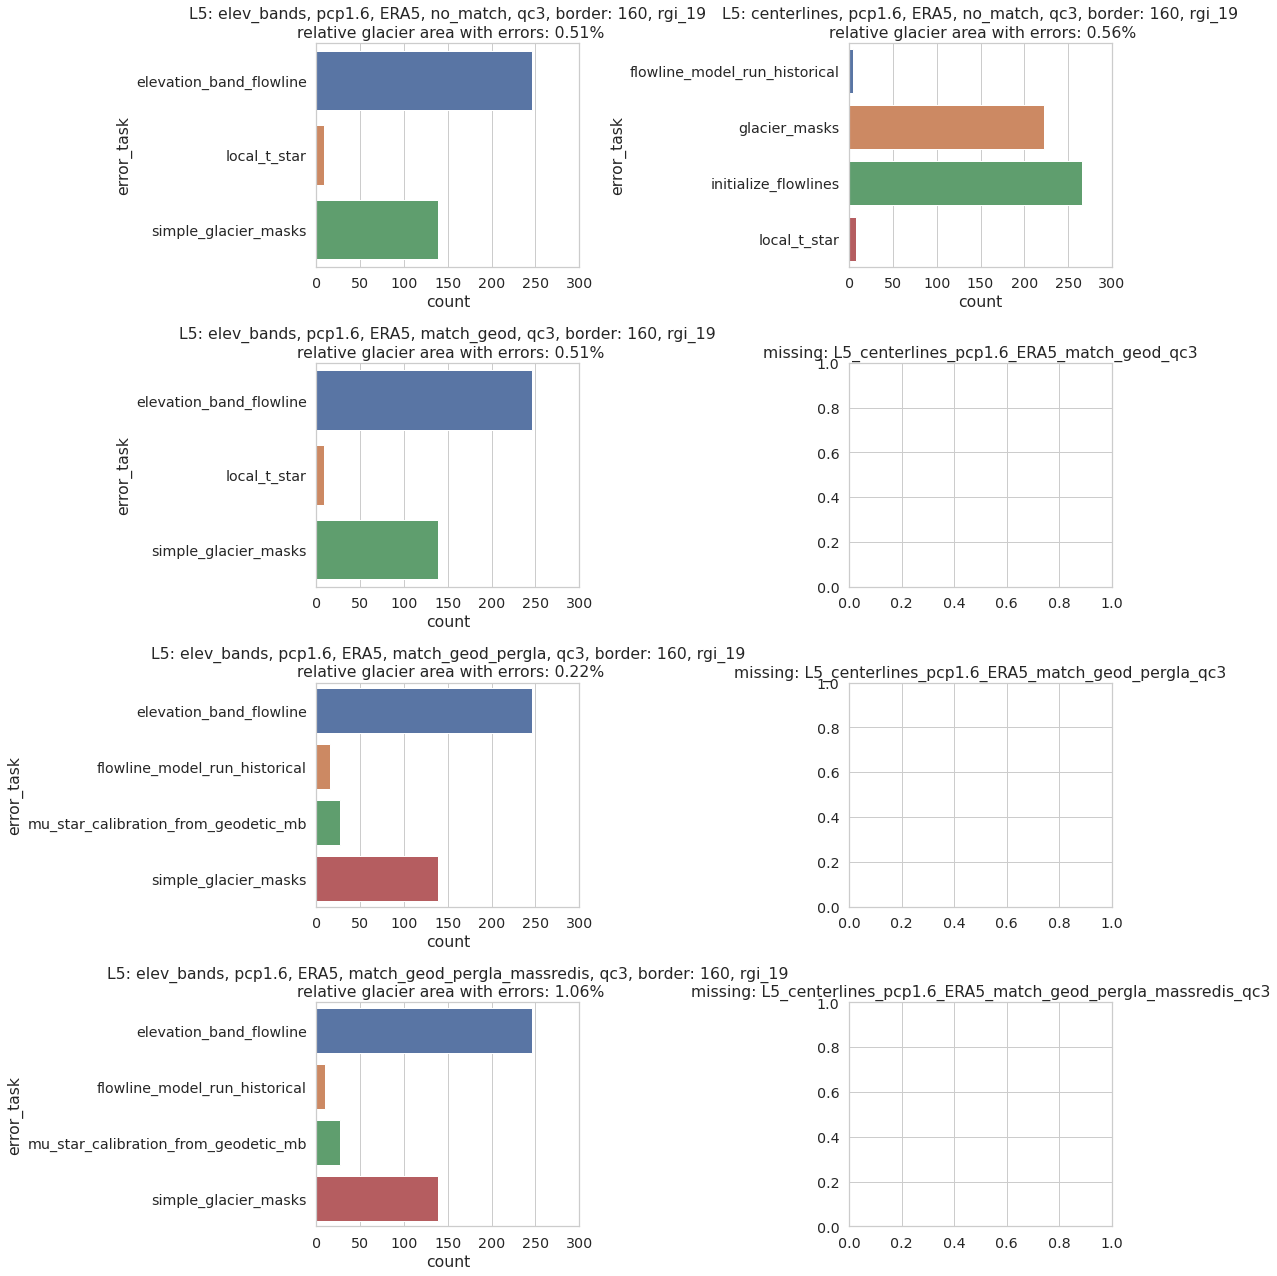

In [38]:
sns.set_style('whitegrid')

exp = 'elev_bands'
qc = 'qc3'
pcp = 'pcp1.6'
clim = 'ERA5'
# when we compare between ERA5 and CRU, we have to omit region 19 because CRU has no climate date for RGI region 19!
rgi_reg = '19'
missing = []
# different match options only available for elev_bands
dfserr_rgi19 = {}
pd_rel_error_area_rgi19 = pd.DataFrame(columns=['rel_error_area_in_percent', 'level', 'exp',
                                              'clim_pcp', 'match', 'qc', 'border', 'rgi_reg'])

plt.figure(figsize=(16,18))
n = 1
for match in ['no_match', 'match_geod', 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
    for exp in ['elev_bands', 'centerlines']:
        plt.subplot(4,2,n)
        n += 1
        try:
            dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr_rgi19, pd_rel_error_area=pd_rel_error_area_rgi19,
                                                              level=level,exp=exp, pcp =pcp, clim=clim, 
                                                              qc=qc,border=border, match=match,
                                                              rgi_reg = rgi_reg,
                                                              subplot=True, xlim=300)
        except:
            missing.append(f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}')
            plt.title(f'missing: {level}_{exp}_{pcp}_{clim}_{match}_{qc}')
plt.tight_layout()


<a id='id-rgi-19'></a>

in RGI 19 with ERA5 and qc3:
- most errors are coming from preprocessing level 2 or lower (e.g. (simple_)glacier_masks or elevation_band_flowline).
- similar as for the other regions, more errors occur for 'no_match' or 'match_geod' than for 'match_geod_pergla'. 
- However, 'match_geod_pergla_massredis' (~1% relative failing glacier area), has twice as large failing glacier area than 'no_match'